In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime
from ipywidgets import interact
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Parámetros
profit = 0  # Initialize profit at the beginning of each day
initial_lost = - 300  # Stop Loss Threshold
new_stop_level = 495
second_stop_level = 1000
n = 5  # Número de velas anteriores a considerar
r = 1   # Rango máximo/mínimo admitido ante de entrar
first_target = 500  # When price gets first target profit,move stop to break even
second_target = 1500

In [3]:
# Definir la ruta del archivo
file_path = os.path.join("Output", "ES_data_5_min_2024_2025.csv")

# Cargar el archivo CSV
df = pd.read_csv(file_path)
summary_df = pd.DataFrame(columns=["date", "profit", "min_profit", "max_profit"])
summary_df = summary_df.round(2)
print("File loaded successfully!")

File loaded successfully!


In [4]:
# Convertir 'date' a formato datetime con UTC
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

# Eliminar la zona horaria y ajustar a minutos
df['date'] = df['date'].dt.tz_localize(None).dt.floor('min')

In [5]:
df['fecha'] = df['date'].dt.date  # Extract only the date part (ignore time)

# Create a mask to rows where the date is the same as the previous row
df['same_day'] = df['fecha'] == df['fecha'].shift(1)

# Apply rolling calculation only when the current row belongs to the same date as the previous row
df['min_last_n'] = df['low'].where(df['same_day']).rolling(window=n, min_periods=n).min().shift(1)
df['max_last_n'] = df['high'].where(df['same_day']).rolling(window=n, min_periods=n).max().shift(1)
df['rango'] = abs(df['max_last_n']-df['min_last_n'])

# Drop helper column
#df.drop(columns=['same_day'], inplace=True)

# Calcular el máximo y mínimo de las últimas `n` velas

#df['min_last_n'] = df['low'].rolling(window=n).min().shift(1)   # Mínimo de las últimas `n` velas
#df['max_last_n'] = df['high'].rolling(window=n).max().shift(1)  # Máximo de las últimas `n` velas

# Definir la señal cuando el cierre rompe el rango de las últimas `n` velas
#df['senyal'] = (df['close'] > df['max_last_n']) | (df['close'] < df['min_last_n'])
# definir los filtros de entrada
df['senyal'] = ((df['close'] > df['max_last_n']) | (df['close'] < df['min_last_n'])) & (df['rango'] > r) # variar r rango como filtro

# No toma en cuenta ninguna senyal de entrda cuando se evalua la primera fila del dia
df.loc[~df['same_day'], 'senyal'] = False
df['profit'] = 0
df['stop'] = initial_lost

In [6]:
# Extraer la fecha sin la hora
df['day'] = df['date'].dt.date

# Inicializar wakeup
df['wakeup'] = False

# Variable para rastrear wakeup
wakeup_active = False
previous_day = None

for i, row in df.iterrows():
    current_day = row['day']

    # Reiniciar wakeup al inicio de un nuevo día
    if current_day != previous_day:
        wakeup_active = False  

    # Marcar wakeup solo si hay una señal de entrada y aún no se ha activado en el día
    if row['senyal'] and not wakeup_active:
        df.at[i, 'wakeup'] = True
        wakeup_active = True  

    previous_day = current_day  

# Eliminar la columna auxiliar 'day'
df.drop(columns=["day","volume", "average"], inplace=True)
df['bias'] = np.where(df['close'] > df['open'], 'Long', 'Short')
df.head(80)

date     open     high      low    close  barCount  \
0  2022-12-29 14:30:00  3805.45  3816.61  3805.45  3814.90       291   
1  2022-12-29 14:35:00  3814.70  3823.41  3814.05  3821.87       289   
2  2022-12-29 14:40:00  3821.97  3830.42  3821.97  3826.48       289   
3  2022-12-29 14:45:00  3826.44  3830.10  3826.24  3829.60       288   
4  2022-12-29 14:50:00  3829.58  3831.46  3824.31  3828.59       284   
5  2022-12-29 14:55:00  3828.74  3832.92  3828.71  3830.84       288   
6  2022-12-29 15:00:00  3830.82  3834.89  3829.16  3830.74       291   
7  2022-12-29 15:05:00  3830.72  3837.56  3829.89  3835.62       284   
8  2022-12-29 15:10:00  3835.60  3839.96  3835.60  3839.39       279   
9  2022-12-29 15:15:00  3839.37  3843.26  3839.37  3843.26       278   
10 2022-12-29 15:20:00  3843.27  3844.15  3840.42  3841.67       283   
11 2022-12-29 15:25:00  3841.72  3841.72  3837.87  3838.26       277   
12 2022-12-29 15:30:00  3838.44  3843.99  3838.44  3843.99       279   
13 2022-12-29 15:35:00  3844.05  3846.09  3843.56  3845.01       281   
14 2022-12-29 15:40:00  3845.09  3846.04  3844.10  3844.41       273   
15 2022-12-29 15:45:00  3844.42  3844.57  3840.96  3841.35       285   
16 2022-12-29 15:50:00  3841.64  3845.32  3841.64  3844.76       280   
17 2022-12-29 15:55:00  3844.75  3847.47  3844.57  3846.64       274   
18 2022-12-29 16:00:00  3847.05  3847.64  3843.76  3844.40       274   
19 2022-12-29 16:05:00  3844.19  3845.07  3840.95  3841.59       270   
20 2022-12-29 16:10:00  3841.60  3842.78  3838.52  3839.89       276   
21 2022-12-29 16:15:00  3839.88  3843.61  3839.64  3842.38       275   
22 2022-12-29 16:20:00  3842.34  3843.40  3840.11  3841.58       269   
23 2022-12-29 16:25:00  3841.61  3844.53  3841.58  3844.05       269   
24 2022-12-29 16:30:00  3844.03  3850.21  3844.03  3849.64       281   
25 2022-12-29 16:35:00  3849.71  3849.76  3848.14  3849.32       273   
26 2022-12-29 16:40:00  3849.33  3850.53  3848.83  3850.22       277   
27 2022-12-29 16:45:00  3850.26  3853.92  3850.12  3853.49       266   
28 2022-12-29 16:50:00  3853.50  3857.28  3853.40  3856.62       270   
29 2022-12-29 16:55:00  3856.60  3856.78  3854.45  3854.61       261   
30 2022-12-29 17:00:00  3854.49  3855.40  3853.09  3853.27       271   
31 2022-12-29 17:05:00  3853.26  3854.65  3851.88  3854.58       265   
32 2022-12-29 17:10:00  3854.73  3856.23  3853.01  3853.01       258   
33 2022-12-29 17:15:00  3852.65  3855.82  3852.01  3855.01       270   
34 2022-12-29 17:20:00  3855.02  3856.37  3854.30  3854.74       262   
35 2022-12-29 17:25:00  3854.68  3854.68  3852.75  3853.33       275   
36 2022-12-29 17:30:00  3853.35  3854.54  3852.06  3852.80       268   
37 2022-12-29 17:35:00  3852.79  3852.96  3848.33  3849.19       263   
38 2022-12-29 17:40:00  3849.22  3851.47  3849.03  3850.89       267   
39 2022-12-29 17:45:00  3851.00  3851.64  3850.10  3850.29       271   
40 2022-12-29 17:50:00  3850.33  3854.37  3850.33  3854.30       257   
41 2022-12-29 17:55:00  3854.29  3854.77  3853.33  3853.71       257   
42 2022-12-29 18:00:00  3853.45  3854.74  3851.72  3851.74       276   
43 2022-12-29 18:05:00  3851.72  3852.19  3847.66  3848.38       277   
44 2022-12-29 18:10:00  3848.32  3851.69  3848.32  3851.41       263   
45 2022-12-29 18:15:00  3851.39  3853.42  3849.90  3851.53       266   
46 2022-12-29 18:20:00  3851.45  3851.68  3849.12  3851.20       261   
47 2022-12-29 18:25:00  3851.18  3852.55  3850.97  3851.23       261   
48 2022-12-29 18:30:00  3851.25  3851.82  3849.18  3851.33       269   
49 2022-12-29 18:35:00  3851.11  3851.40  3849.10  3851.40       254   
50 2022-12-29 18:40:00  3851.39  3853.80  3851.39  3853.39       261   
51 2022-12-29 18:45:00  3853.40  3854.10  3851.55  3852.35       255   
52 2022-12-29 18:50:00  3852.43  3853.39  3851.36  3853.39       269   
53 2022-12-29 18:55:00  3853.38  3854.40  3851.63  3853.98       267   
54 2022-12-29 19:00:00  3853.97  3857.26  3853.89  3856.64

In [7]:
def get_last_index_for_date(df, fecha_col, target_date):
    """
    Returns the index number where the next row's value in the specified 'fecha' column 
    is different from the current row for a given target date.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    fecha_col (str): The column name representing the date.
    target_date (str or datetime): The specific date to filter.

    Returns:
    int or None: The index number where the date changes, or None if no such index exists.
    """
    # Ensure fecha column is in datetime format
    df[fecha_col] = pd.to_datetime(df[fecha_col])

    # Ensure target_date is a datetime object (if given as string)
    target_date = pd.to_datetime(target_date).date()

    # Filter DataFrame to only include rows for the target date
    df_filtered = df[df[fecha_col].dt.date == target_date]

    # If no rows match the target date, return None
    if df_filtered.empty:
        print(f"No data found for {target_date}")
        return None

    # Get the last index for the target date
    last_index = df_filtered.index[-1]

    #print(f"Last index for {target_date} where '{fecha_col}' changes: {last_index}")
    return last_index

In [8]:
# Initialize variables
entry_price = None
entry_bias = None
profit_values = []
stop_values = []  # List to track stop loss values per row
previous_day = None

# Set the initial stop-loss value before iteration
lost = initial_lost  

# Iterate over each row in the DataFrame
for i, row in df.iterrows():
    current_day = row['date'].date()  # Ensure 'date' is in datetime format

    # Reset profit and entry at the start of a new day
    if previous_day is not None and current_day != previous_day:
        profit = 0
        entry_price = None
        entry_bias = None
        lost = initial_lost  # Reset stop-loss at the beginning of each day

    # Set entry price and bias if conditions are met
    if row['senyal'] and row['wakeup']:
        entry_price = row['close']
        entry_bias = row['bias']
        lost = initial_lost  # Reset stop-loss when a new entry occurs

    # Calculate profit based on trade direction
    if entry_price is not None:
        if entry_bias == "Long":
            profit = (row['close'] - entry_price) * 50
        elif entry_bias == "Short":
            profit = (entry_price - row['close']) * 50
        else:
            profit = 0

        # ✅ Move stop loss to new level **only if profit exceeds first_target**
        if profit > first_target:
            lost = new_stop_level  # Move stop loss to new level
            
        # ✅ Move stop loss to new level **only if profit exceeds first_target**
        if profit > second_target:
            lost = second_stop_level  # Move stop loss to new level

        # ✅ Apply Stop Loss: If profit falls below 'lost', exit trade
        if profit <= lost:
            profit = lost  # Register the stop loss hit
            entry_price = None  # Exit trade
            entry_bias = None  # Reset trade bias

    # Store profit and stop-loss values per row
    profit_values.append(profit)
    stop_values.append(lost)  # Store the stop level for each row

    # Update previous day tracker
    previous_day = current_day

# Convert lists to Pandas Series and assign to DataFrame
df['profit'] = pd.Series(profit_values, index=df.index)
df['stop'] = pd.Series(stop_values, index=df.index)  # Store dynamic stop-loss values


In [9]:
# Drop the 'barCount' column
df = df.drop(columns=['barCount'], errors='ignore')
# Count unique values in 'fecha' column
unique_fecha_count = df["fecha"].nunique()
print(f"Number of different values in 'fecha' column: {unique_fecha_count}")
print(f"Total rows in df: {len(df)}")

Number of different values in 'fecha' column: 538
Total rows in df: 41772


In [10]:
def plot_wakeup_signals(df, target_date, summary_df=None, save_folder="Chart"):
    """
    Generates a plot for wakeup signals, calculates the profit, and appends the result to summary_df.

    Parameters:
    df (pd.DataFrame): Market data DataFrame.
    target_date (str): Date in 'YYYY-MM-DD' format to analyze.
    summary_df (pd.DataFrame, optional): DataFrame to store the daily profit sum.
    save_folder (str): Folder where the chart image will be saved.

    Returns:
    str: Path to the saved image.
    pd.DataFrame: Updated summary_df with profit data, min profit, and max profit.
    """
    os.makedirs(save_folder, exist_ok=True)

    # Filter data for the specified date within the trading hours
    #df_day = df[(df['date'] >= f'{target_date} 12:00') & (df['date'] < f'{target_date} 22:00')].copy()
    df_day = df[(df['date'] >= f'{target_date} 00:00') & (df['date'] < f'{target_date} 23:59')].copy()

    

    # If no data exists for this date, return None
    if df_day.empty:
        print(f"No data available for {target_date}.")
        return None, summary_df

    df_wakeup = df_day[df_day['wakeup']]  # Get wakeup signals

    # Calculate the total profit for the day
    daily_profit = df_day["profit"].sum()

    # Get the last index and its corresponding profit
    last_index = get_last_index_for_date(df, "fecha", target_date)
    if last_index is not None and last_index in df.index:
        profit_value = df.at[last_index, "profit"]
        plot_stop_value = df.at[last_index, "stop"]
        #print(f"The stop value at index {last_index} is: {plot_stop_value}")
        #formatted_profit = f"{profit_value:,.2f}"
        formatted_profit = profit_value
    else:
        print(f"No valid profit data for {target_date}.")
        return None, summary_df

    # Calculate the min and max profit for the day
    min_profit = df_day["profit"].min()
    max_profit = df_day["profit"].max()

    #formatted_min_profit = f"{min_profit:.2f}"
    #formatted_max_profit = f"{max_profit:.2f}"
    formatted_min_profit = min_profit
    formatted_max_profit = max_profit
    
    # Ensure summary_df is initialized and append the new row with additional min/max columns
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["date", "profit", "min_profit", "max_profit"])

    new_row = pd.DataFrame({
        "date": [target_date],
        "profit": [formatted_profit],
        "min_profit": [formatted_min_profit],
        "max_profit": [formatted_max_profit]
    })
    
    summary_df = pd.concat([summary_df, new_row], ignore_index=True)  # Append new row correctly
    #print(summary_df)  # Debugging: Show the updated summary_df

    # Define colors based on bias (Long = green, Short = red)
    colors = df_wakeup['bias'].map({'Long': 'green', 'Short': 'red'})

    # Create the figure with subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Subplot 1: Close price and wakeup signals
    ax[0].plot(df_day['date'], df_day['close'], color='blue', linewidth=1.5, label='Close Price')
    ax[0].scatter(df_wakeup['date'], df_wakeup['close'], color=colors, label='Wakeup Signal', s=80, marker='o', edgecolors='black')

    # Draw horizontal lines for max_last_n and min_last_n in the last 10 rows before each wakeup signal
    for index, row in df_wakeup.iterrows():
        prev_10 = df_day.loc[:index].iloc[-10:]  # Get the last 10 rows before the signal
        if not prev_10.empty:
            max_last_n_value = prev_10['max_last_n'].iloc[-1]  # Last value of max_last_n
            min_last_n_value = prev_10['min_last_n'].iloc[-1]  # Last value of min_last_n

            # Green line for max_last_n
            ax[0].hlines(y=max_last_n_value, xmin=prev_10['date'].iloc[0], xmax=row['date'], 
                         colors='green', linestyles='-', linewidth=1, label='Max Last 10')

            # Red line for min_last_n
            ax[0].hlines(y=min_last_n_value, xmin=prev_10['date'].iloc[0], xmax=row['date'], 
                         colors='red', linestyles='-', linewidth=1, label='Min Last 10')

    ax[0].set_ylabel("Close Price")
    ax[0].set_title(f"Close Price & Wakeup Signals for {target_date}")
    ax[0].grid(axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
    ax[0].legend(loc='upper right')

    # Subplot 2: Profit area chart
    ax[1].fill_between(df_day['date'], df_day['profit'], where=(df_day['profit'] >= 0), color='green', alpha=0.5, label='Profit > 0')
    ax[1].fill_between(df_day['date'], df_day['profit'], where=(df_day['profit'] < 0), color='red', alpha=0.5, label='Profit < 0')
    ax[1].axhline(0, color='black', linewidth=1, linestyle='-')
    ax[1].axhline(y=plot_stop_value, color='orange', linestyle='--', linewidth=1.5, label='Stop Loss Level')
    ax[1].set_ylabel("Profit")
    ax[1].set_xlabel("Time")
    ax[1].legend(loc='upper right')
    ax[1].grid(axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
    

    plt.xticks(rotation=45)
    
    # Adjust the space between subplots
    plt.subplots_adjust(hspace=0.05)  

    # Save the image
    save_path = os.path.join(save_folder, f"wakeup_signals_{target_date}.jpg")
    plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()
    
    formatted_profit =round(formatted_profit,2)
    formatted_min_profit = round(formatted_min_profit,2)
    formatted_max_profit = round(formatted_max_profit,2)

    print(f"El beneficio al final del día {target_date} en índice {last_index} es: {formatted_profit} $") 
    print(f"Min Profit of the day: {formatted_min_profit} $")
    print(f"Max Profit of the day: {formatted_max_profit} $")
    print(f"Chart saved successfully: {save_path}")

    return save_path, summary_df  # Return updated summary_df

In [11]:
def display_chart(date):
    plot_wakeup_signals(df, date, summary_df)

In [12]:
interact(display_chart, date='2022-12-30')

interactive(children=(Text(value='2022-12-30', description='date'), Output()), _dom_classes=('widget-interact'…

<function __main__.display_chart(date)>

In [13]:
# Extraer fechas únicas
df['date'] = pd.to_datetime(df['date'])
unique_dates = df['date'].dt.date.unique()
formatted_dates = [date.strftime('%Y-%m-%d') for date in unique_dates]
#print(formatted_dates)

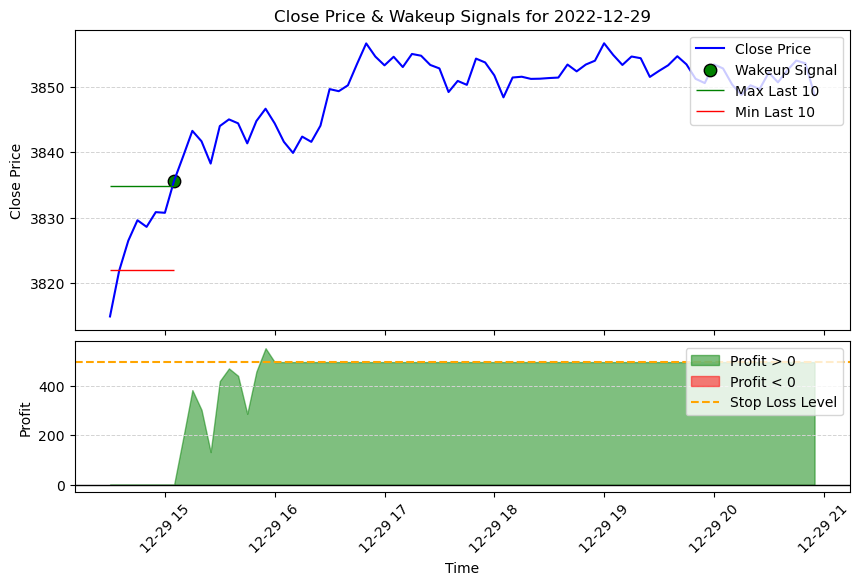

El beneficio al final del día 2022-12-29 en índice 77 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 551.0 $
Chart saved successfully: Chart\wakeup_signals_2022-12-29.jpg


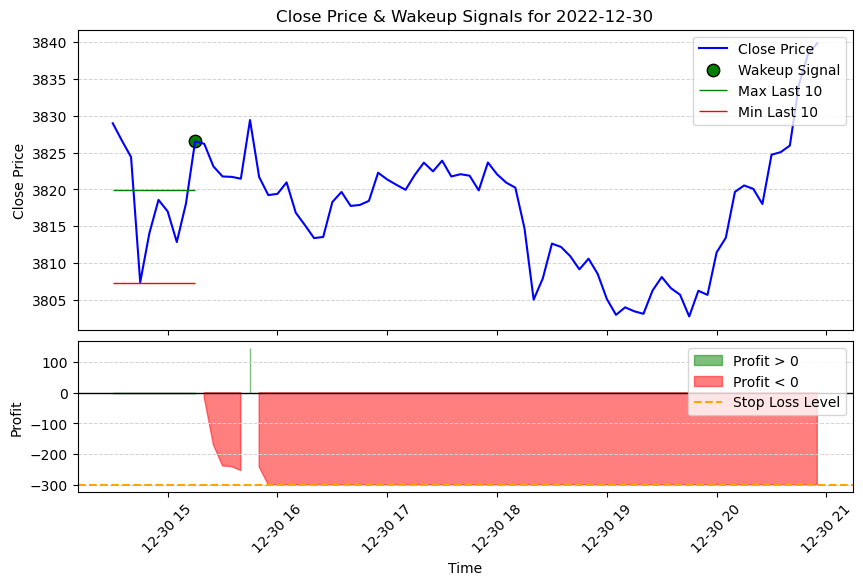

El beneficio al final del día 2022-12-30 en índice 155 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 145.0 $
Chart saved successfully: Chart\wakeup_signals_2022-12-30.jpg


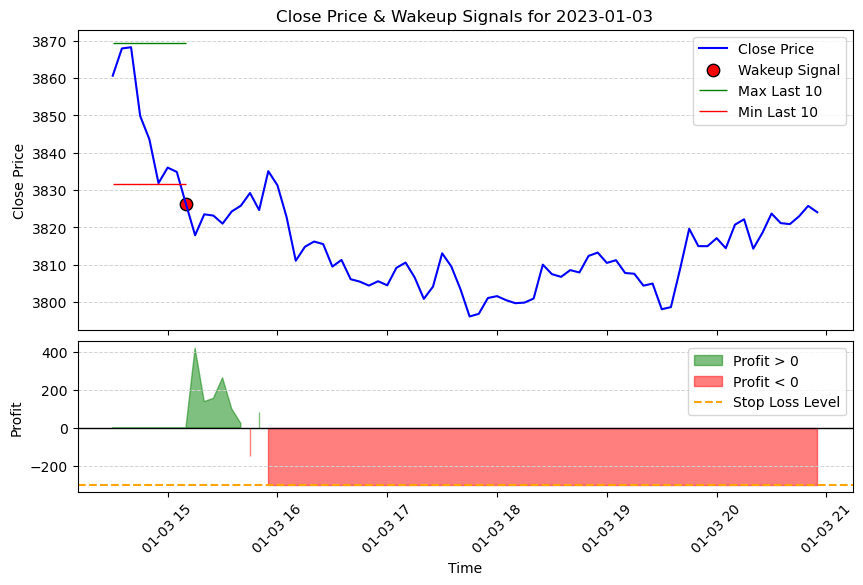

El beneficio al final del día 2023-01-03 en índice 233 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 418.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-03.jpg


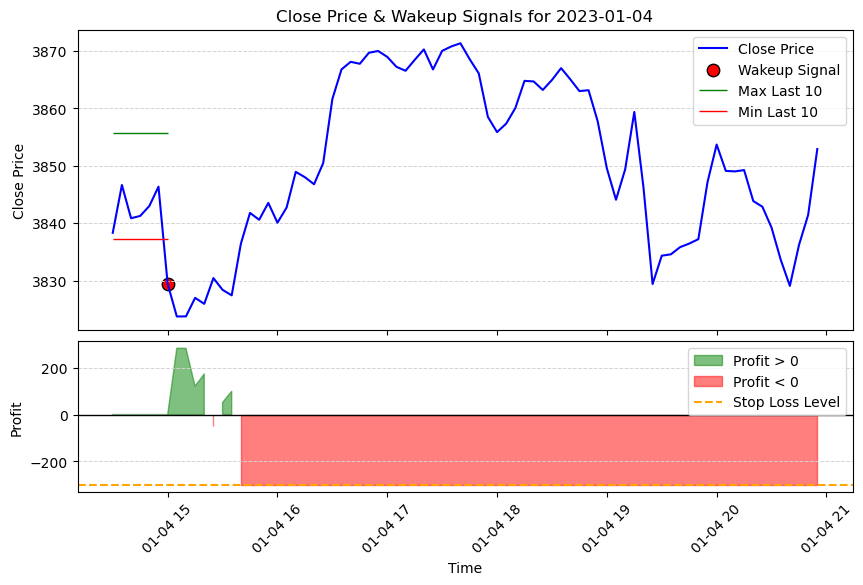

El beneficio al final del día 2023-01-04 en índice 311 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 284.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-04.jpg


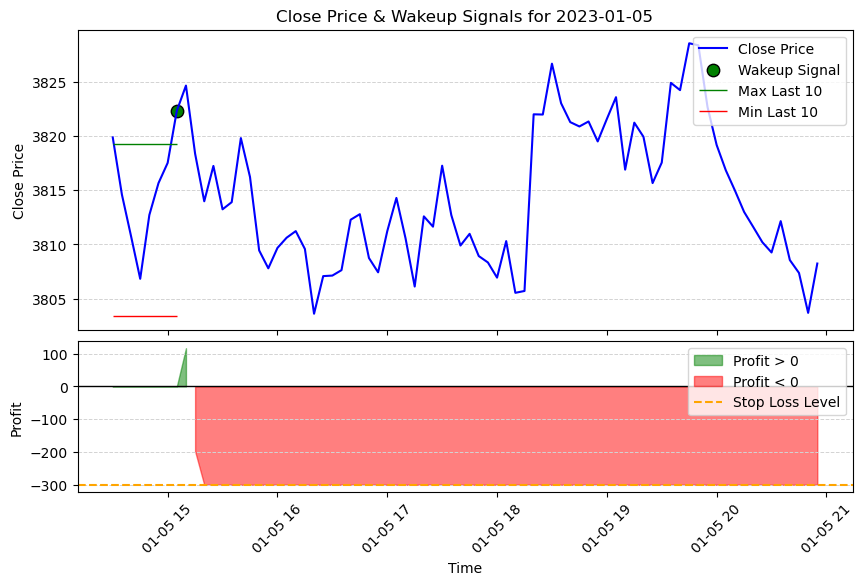

El beneficio al final del día 2023-01-05 en índice 389 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 116.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-05.jpg


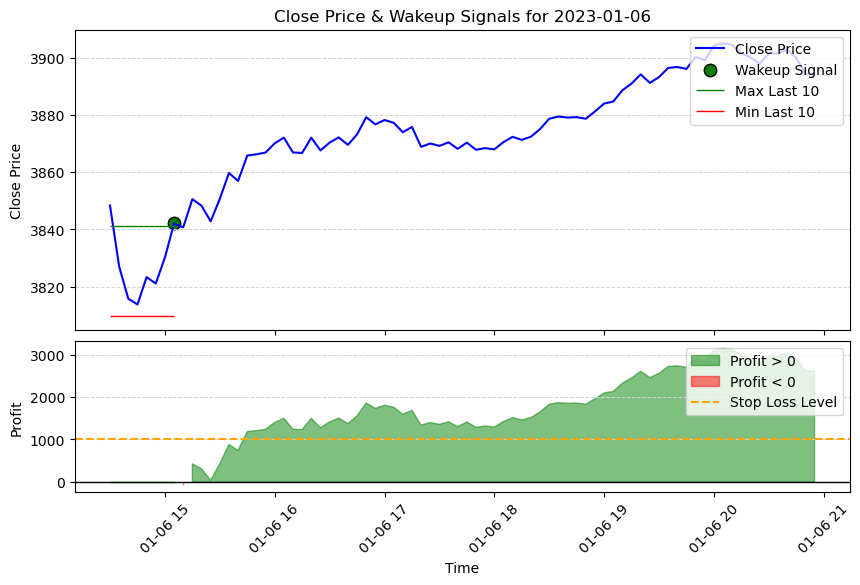

El beneficio al final del día 2023-01-06 en índice 467 es: 2605.0 $
Min Profit of the day: -69.0 $
Max Profit of the day: 3149.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-06.jpg


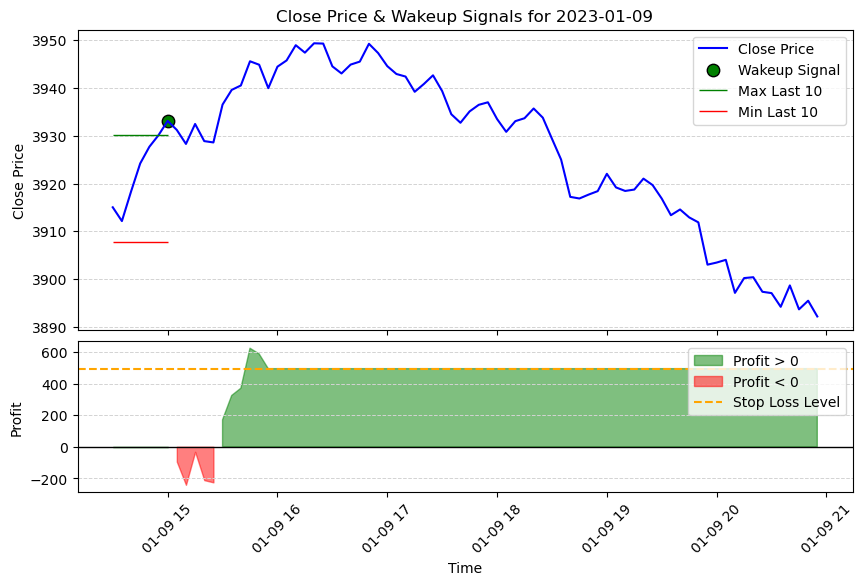

El beneficio al final del día 2023-01-09 en índice 545 es: 495.0 $
Min Profit of the day: -241.0 $
Max Profit of the day: 624.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-09.jpg


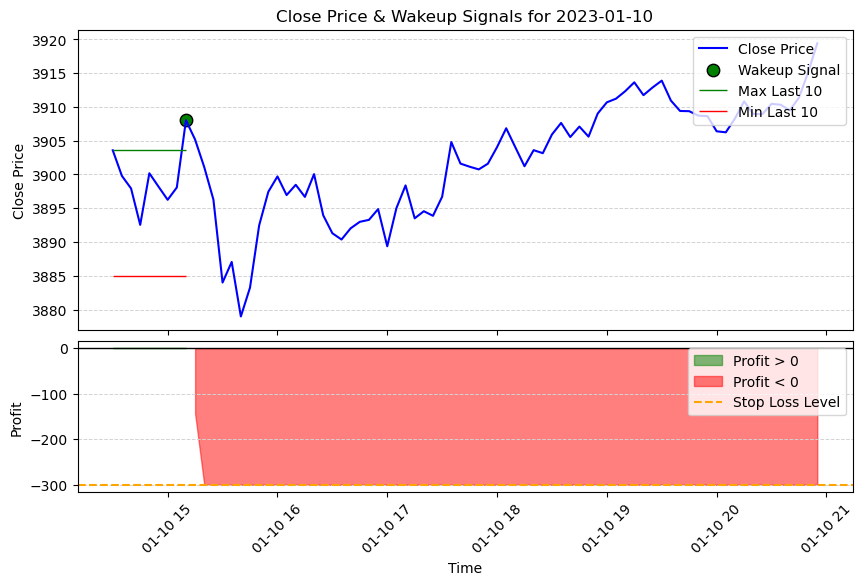

El beneficio al final del día 2023-01-10 en índice 623 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-10.jpg


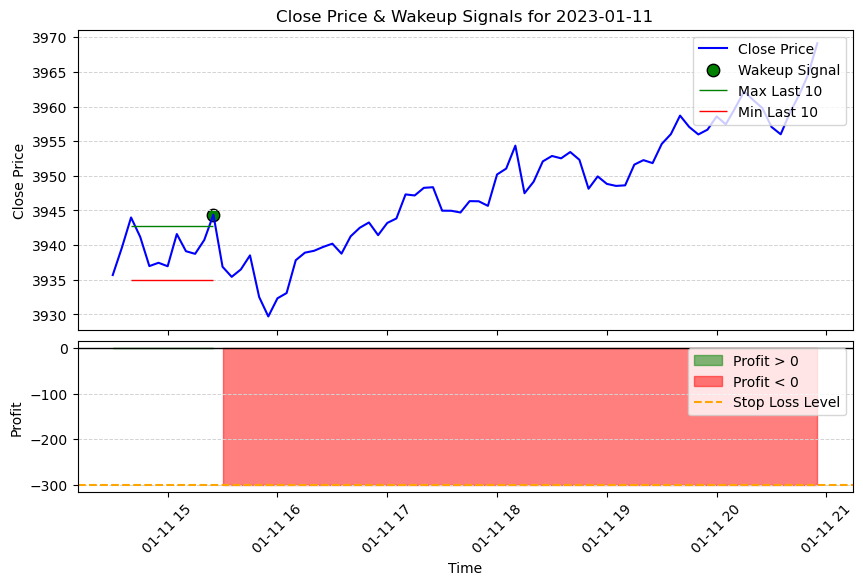

El beneficio al final del día 2023-01-11 en índice 701 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-11.jpg


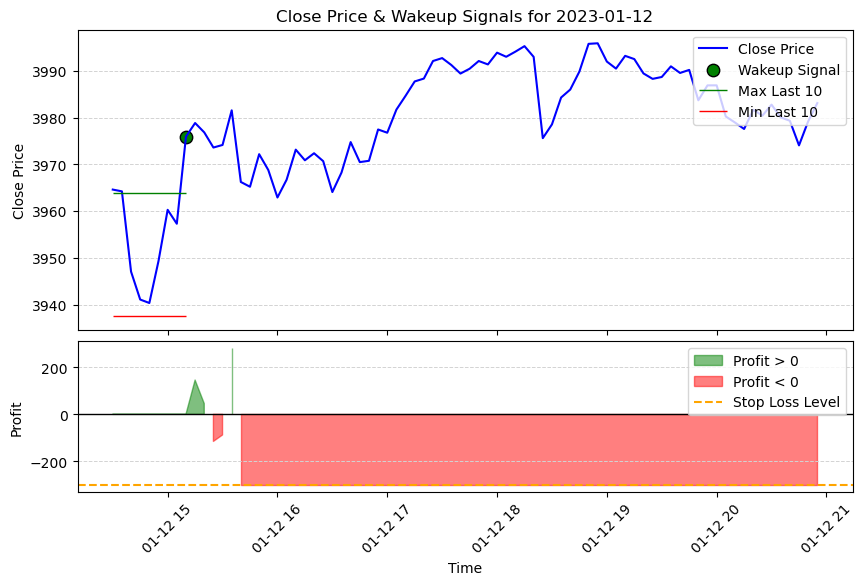

El beneficio al final del día 2023-01-12 en índice 779 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 281.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-12.jpg


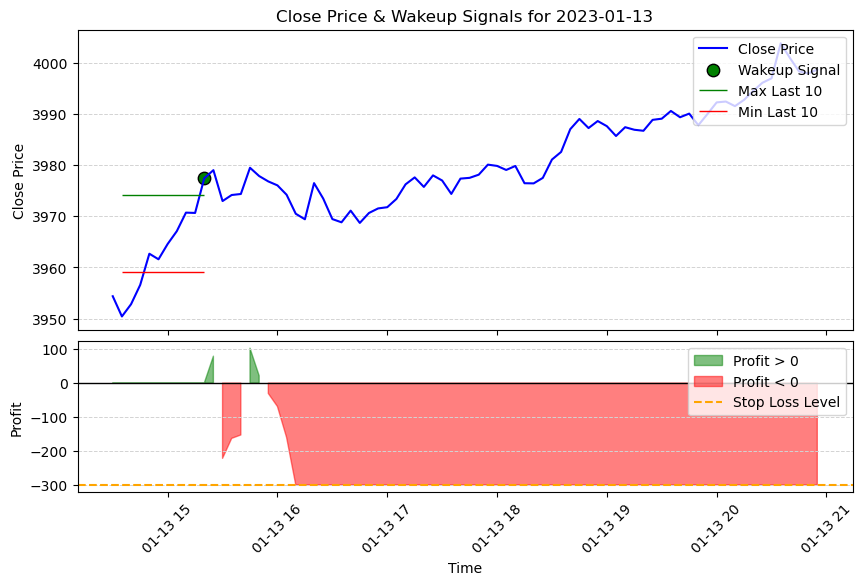

El beneficio al final del día 2023-01-13 en índice 857 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 103.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-13.jpg


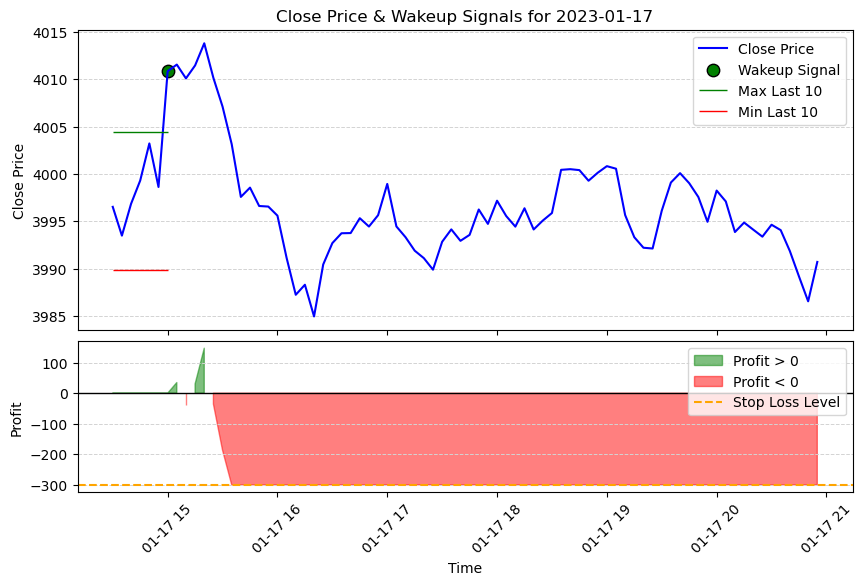

El beneficio al final del día 2023-01-17 en índice 935 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 147.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-17.jpg


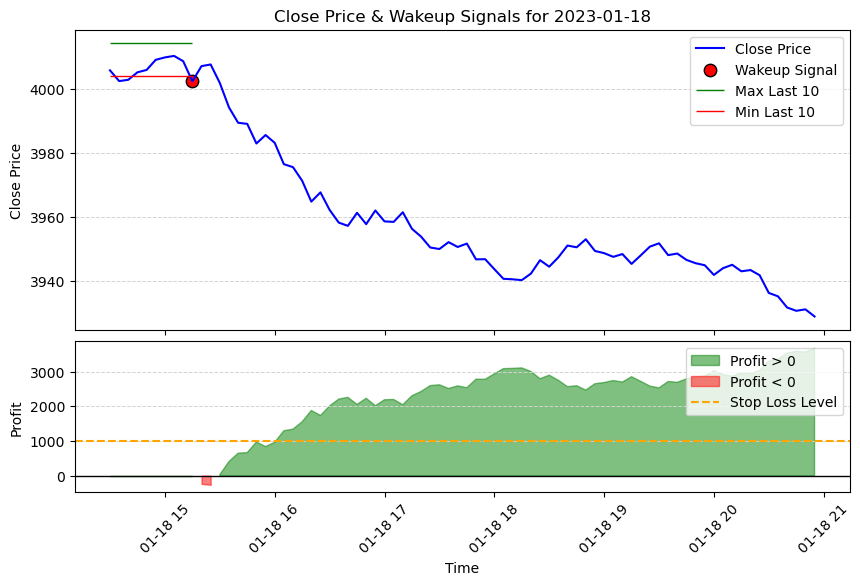

El beneficio al final del día 2023-01-18 en índice 1013 es: 3671.0 $
Min Profit of the day: -262.5 $
Max Profit of the day: 3671.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-18.jpg


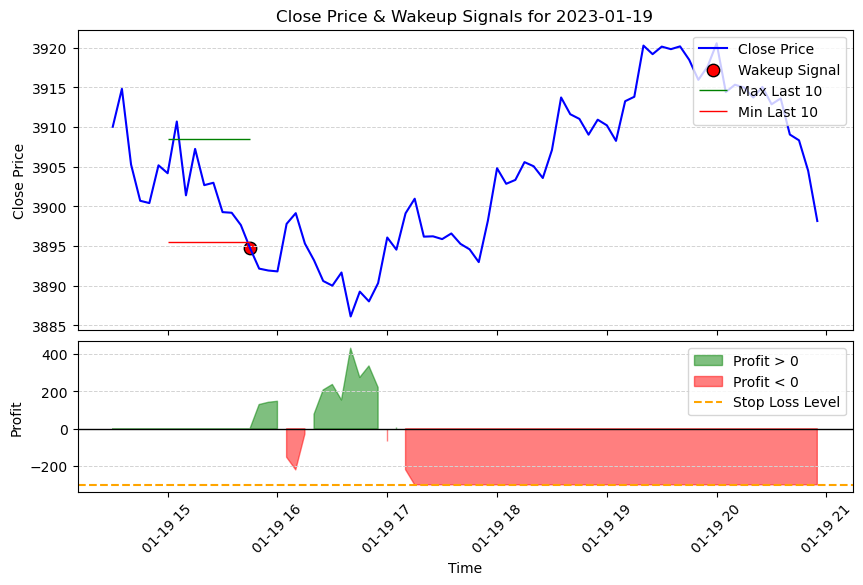

El beneficio al final del día 2023-01-19 en índice 1091 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 431.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-19.jpg


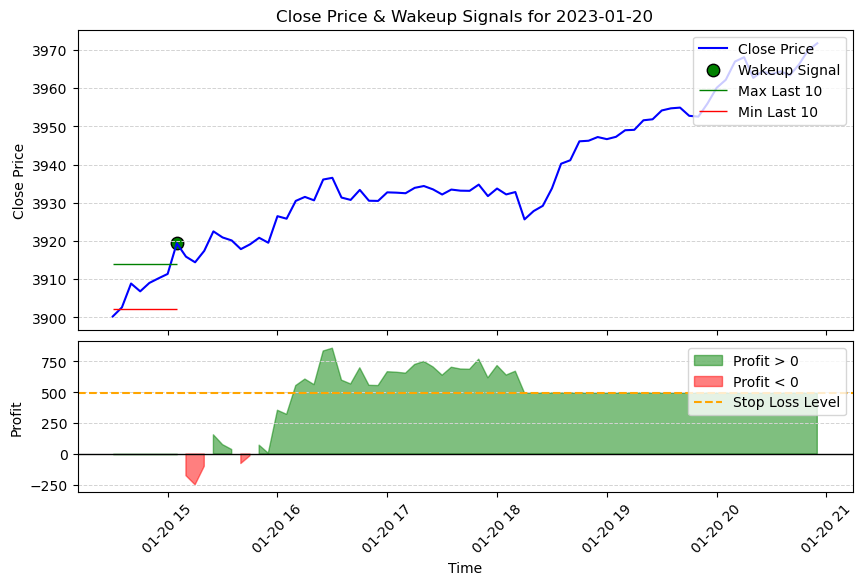

El beneficio al final del día 2023-01-20 en índice 1169 es: 495.0 $
Min Profit of the day: -249.0 $
Max Profit of the day: 857.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-20.jpg


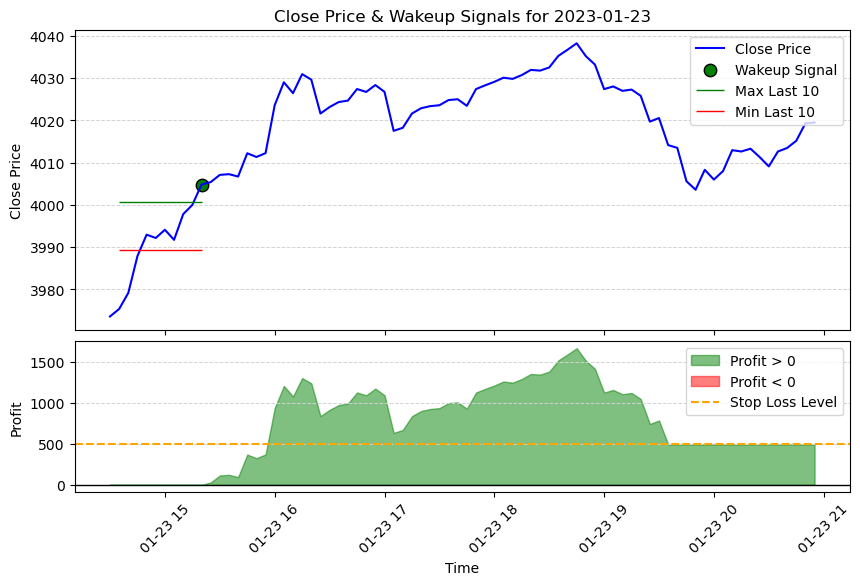

El beneficio al final del día 2023-01-23 en índice 1247 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 1672.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-23.jpg


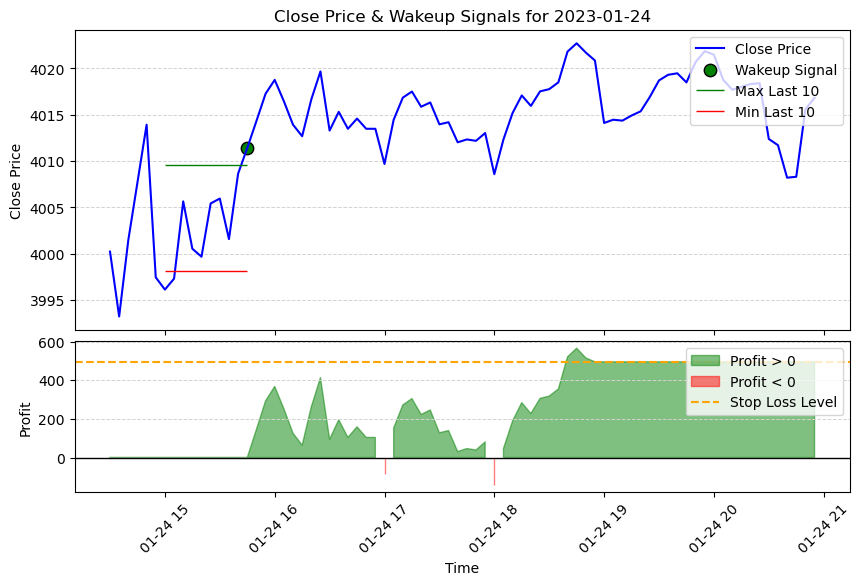

El beneficio al final del día 2023-01-24 en índice 1325 es: 495.0 $
Min Profit of the day: -141.0 $
Max Profit of the day: 565.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-24.jpg


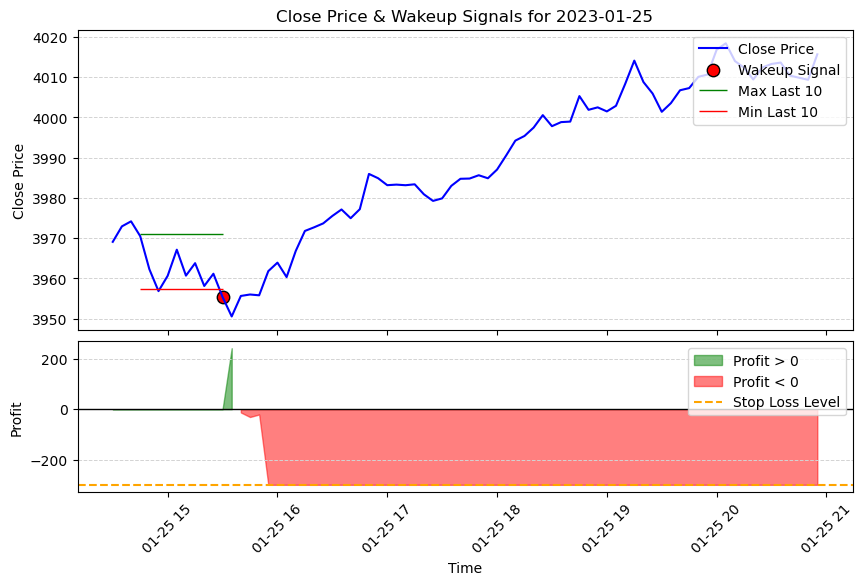

El beneficio al final del día 2023-01-25 en índice 1403 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 242.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-25.jpg


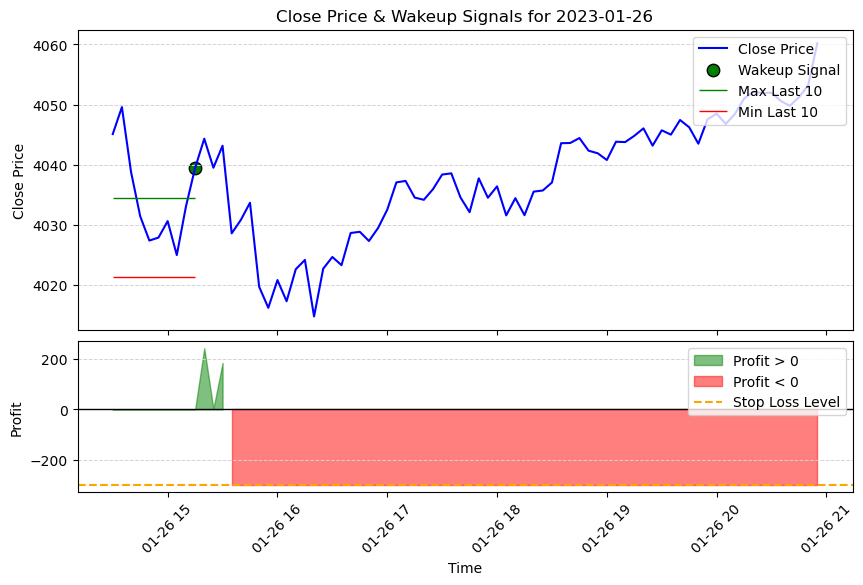

El beneficio al final del día 2023-01-26 en índice 1481 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 243.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-26.jpg


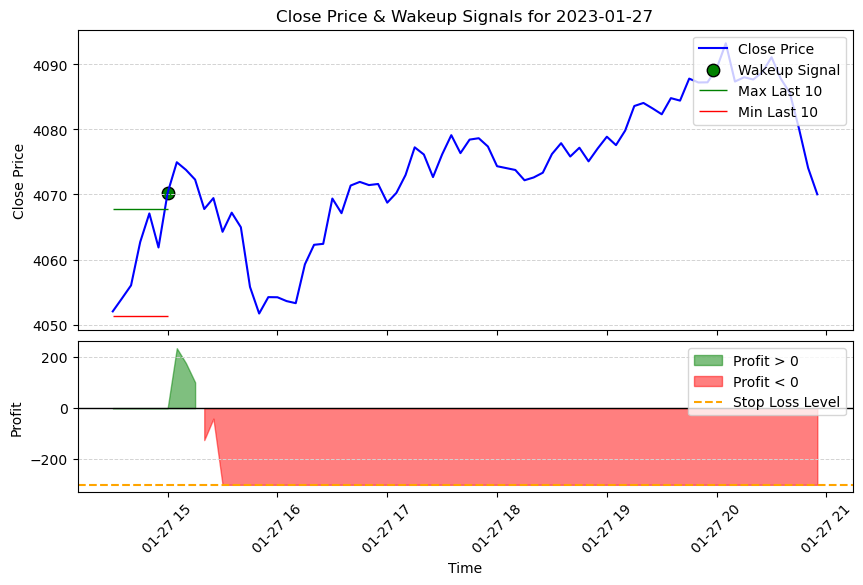

El beneficio al final del día 2023-01-27 en índice 1559 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 234.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-27.jpg


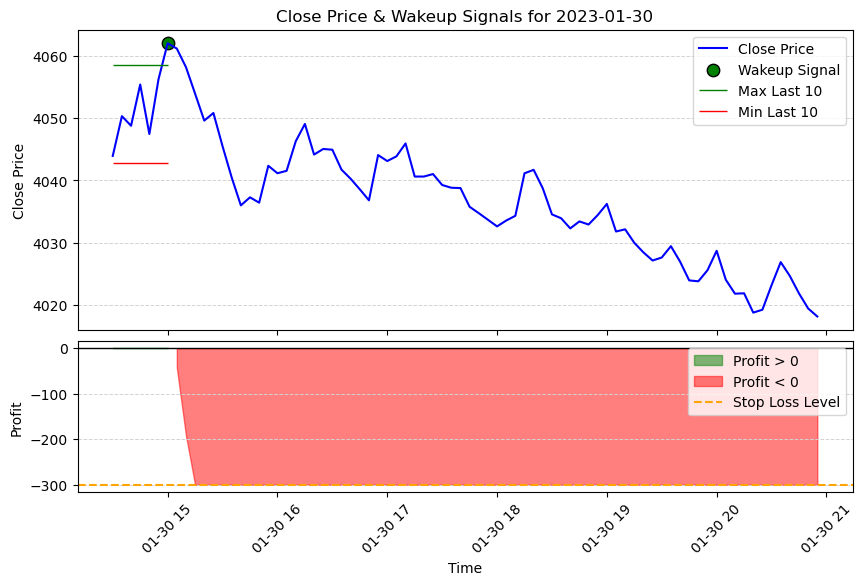

El beneficio al final del día 2023-01-30 en índice 1637 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-01-30.jpg


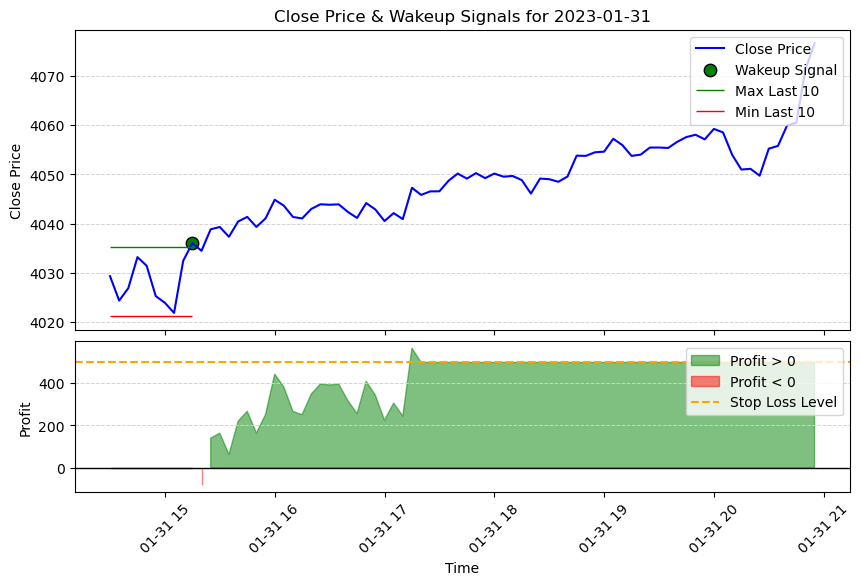

El beneficio al final del día 2023-01-31 en índice 1715 es: 495.0 $
Min Profit of the day: -78.5 $
Max Profit of the day: 561.5 $
Chart saved successfully: Chart\wakeup_signals_2023-01-31.jpg


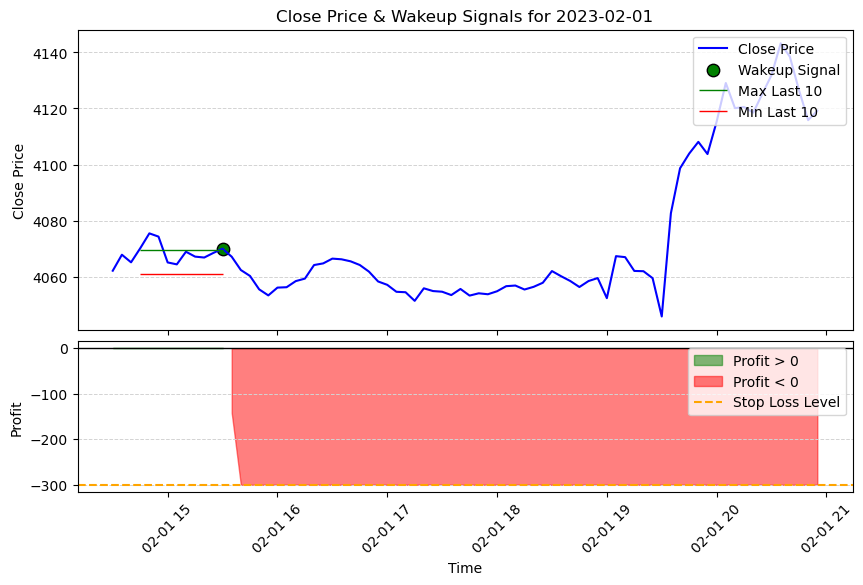

El beneficio al final del día 2023-02-01 en índice 1793 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-01.jpg


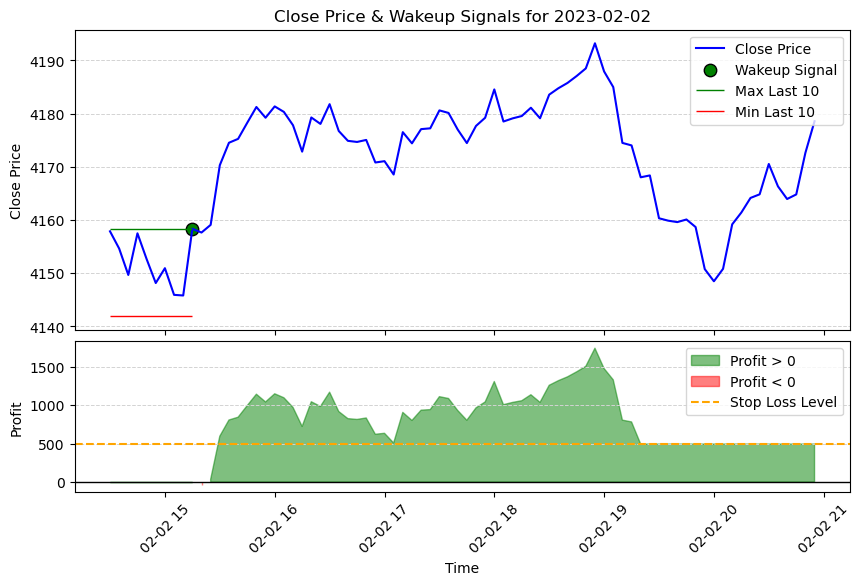

El beneficio al final del día 2023-02-02 en índice 1871 es: 495.0 $
Min Profit of the day: -35.0 $
Max Profit of the day: 1743.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-02.jpg


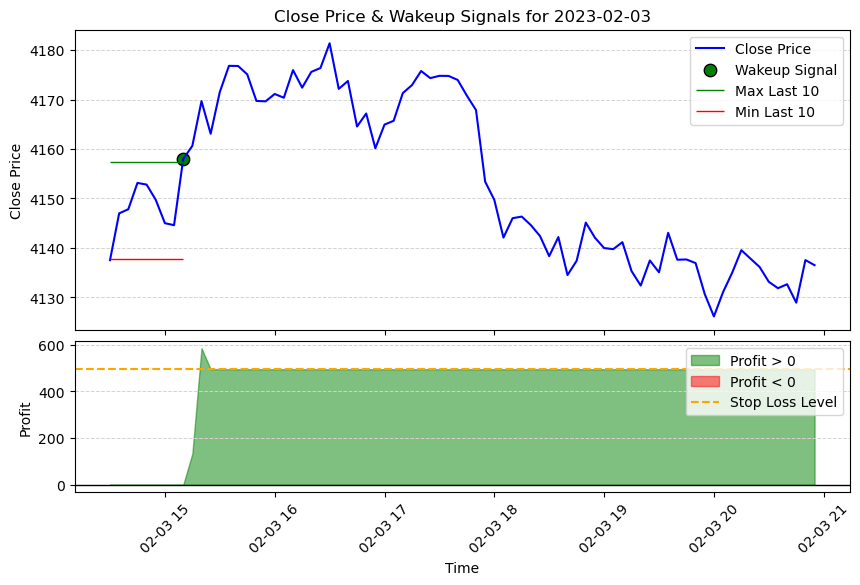

El beneficio al final del día 2023-02-03 en índice 1949 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 585.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-03.jpg


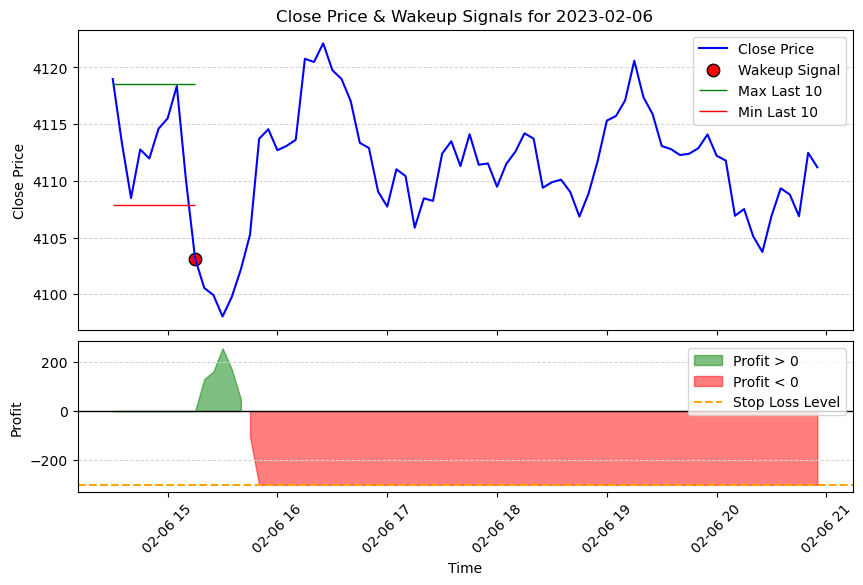

El beneficio al final del día 2023-02-06 en índice 2027 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 255.5 $
Chart saved successfully: Chart\wakeup_signals_2023-02-06.jpg


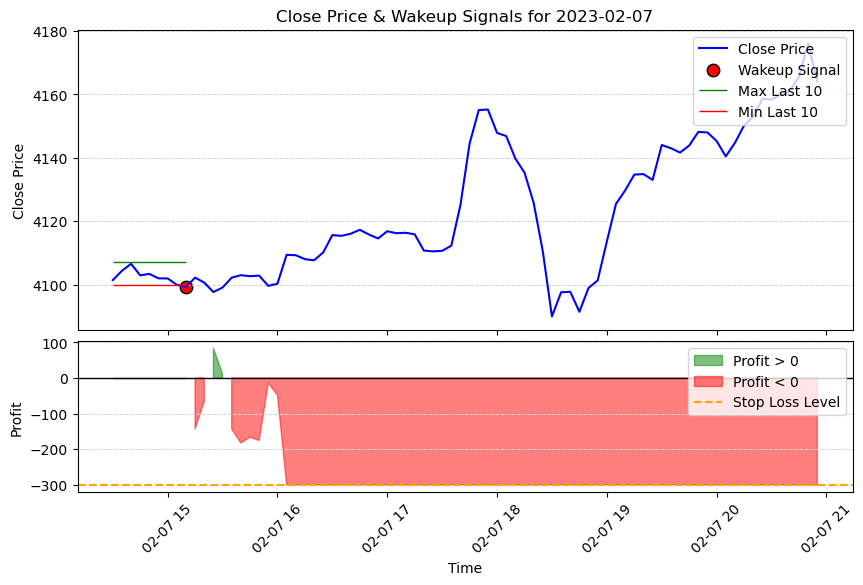

El beneficio al final del día 2023-02-07 en índice 2105 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 83.5 $
Chart saved successfully: Chart\wakeup_signals_2023-02-07.jpg


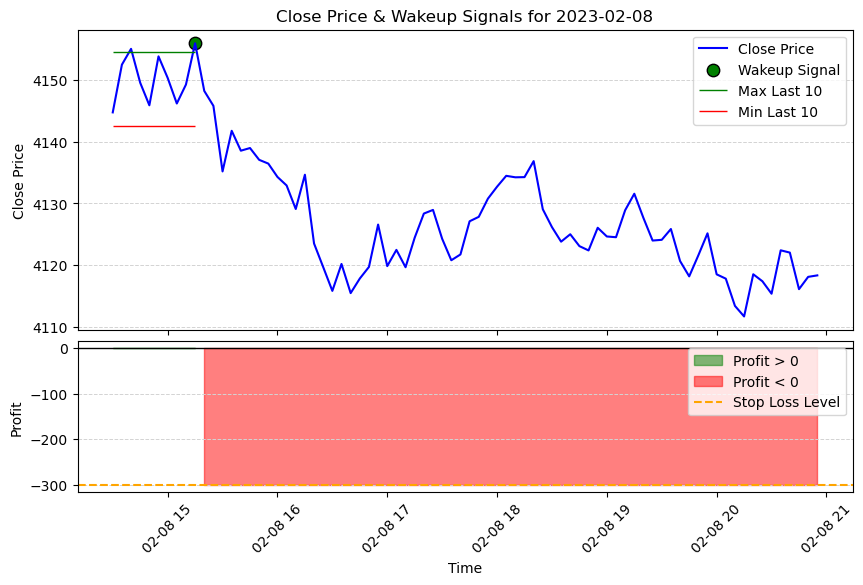

El beneficio al final del día 2023-02-08 en índice 2183 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-08.jpg


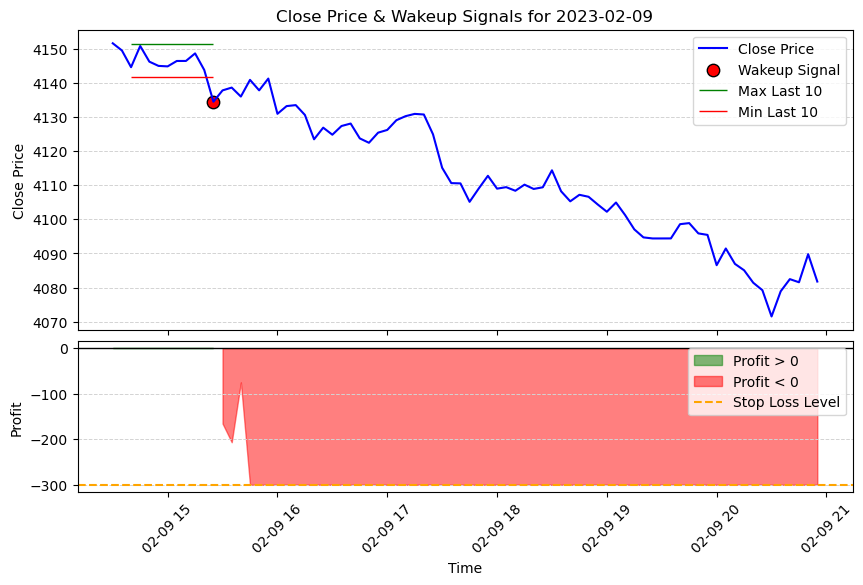

El beneficio al final del día 2023-02-09 en índice 2261 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-09.jpg


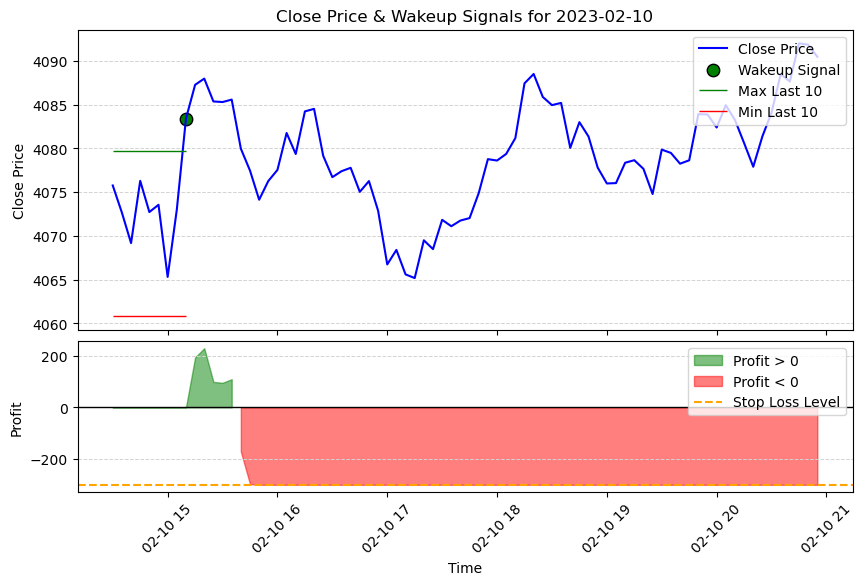

El beneficio al final del día 2023-02-10 en índice 2339 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 229.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-10.jpg


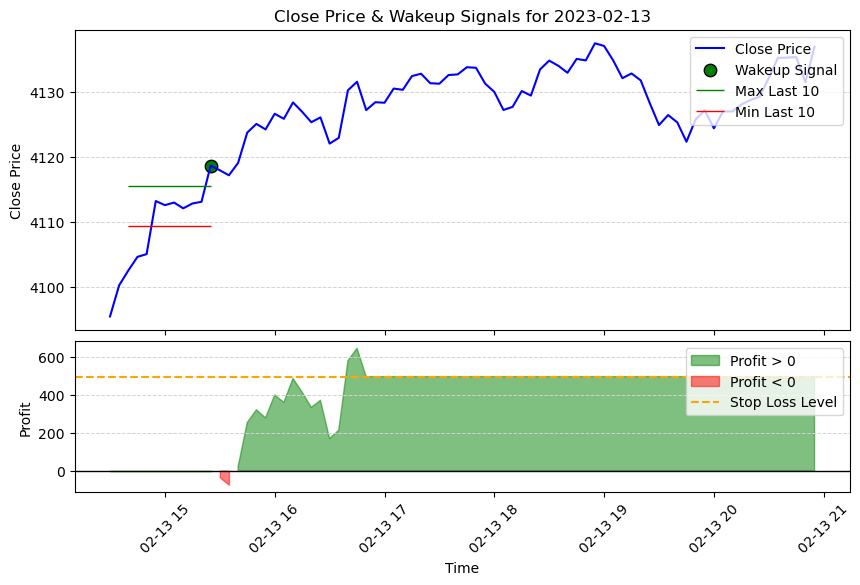

El beneficio al final del día 2023-02-13 en índice 2417 es: 495.0 $
Min Profit of the day: -74.5 $
Max Profit of the day: 644.5 $
Chart saved successfully: Chart\wakeup_signals_2023-02-13.jpg


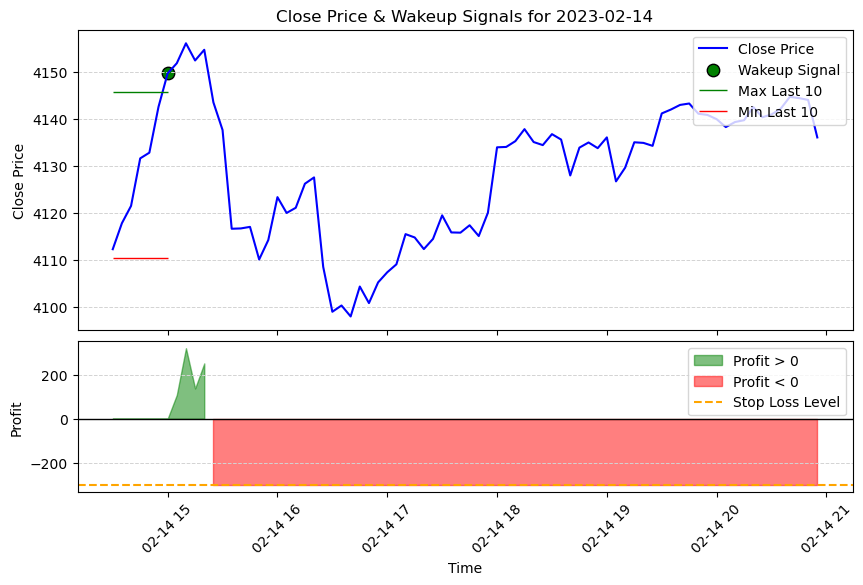

El beneficio al final del día 2023-02-14 en índice 2495 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 320.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-14.jpg


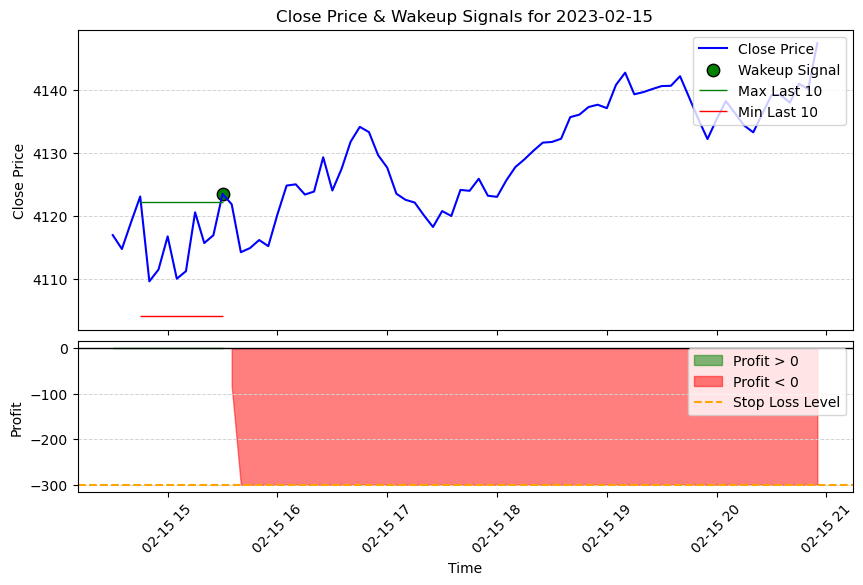

El beneficio al final del día 2023-02-15 en índice 2573 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-15.jpg


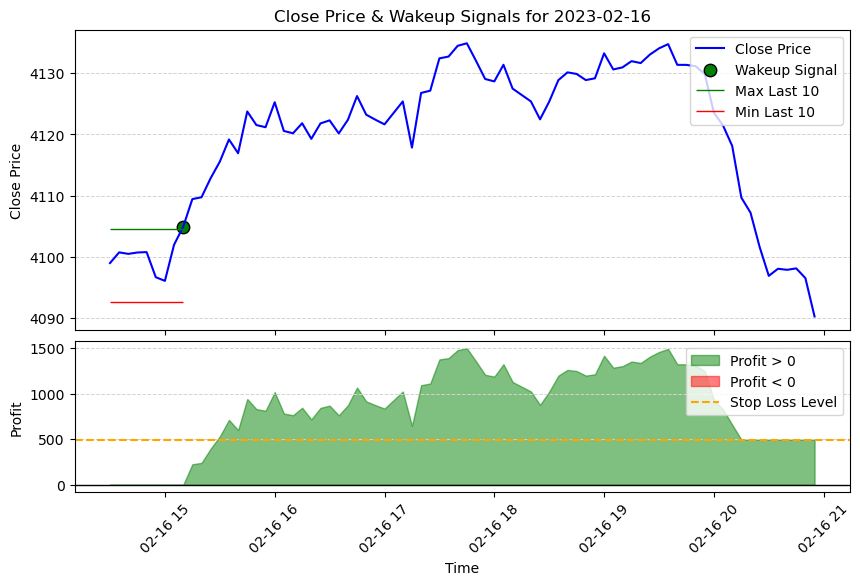

El beneficio al final del día 2023-02-16 en índice 2651 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 1498.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-16.jpg


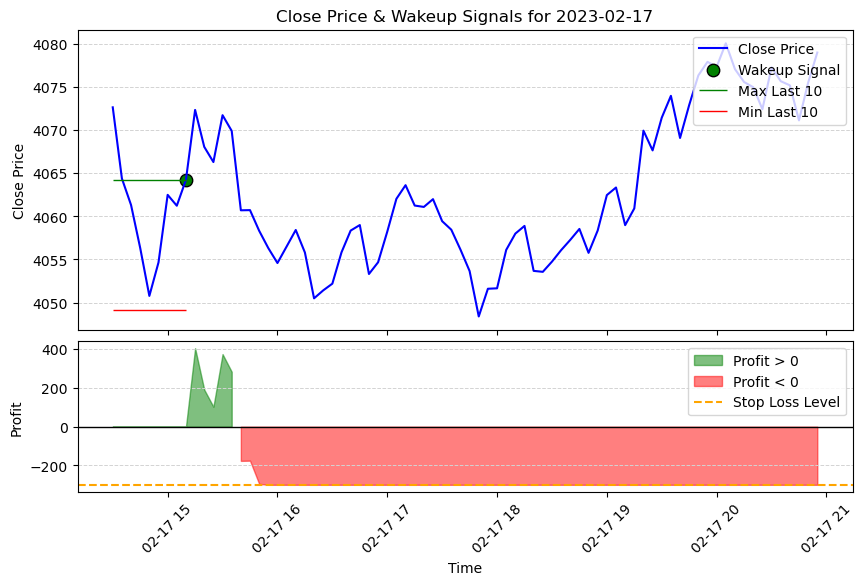

El beneficio al final del día 2023-02-17 en índice 2729 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 405.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-17.jpg


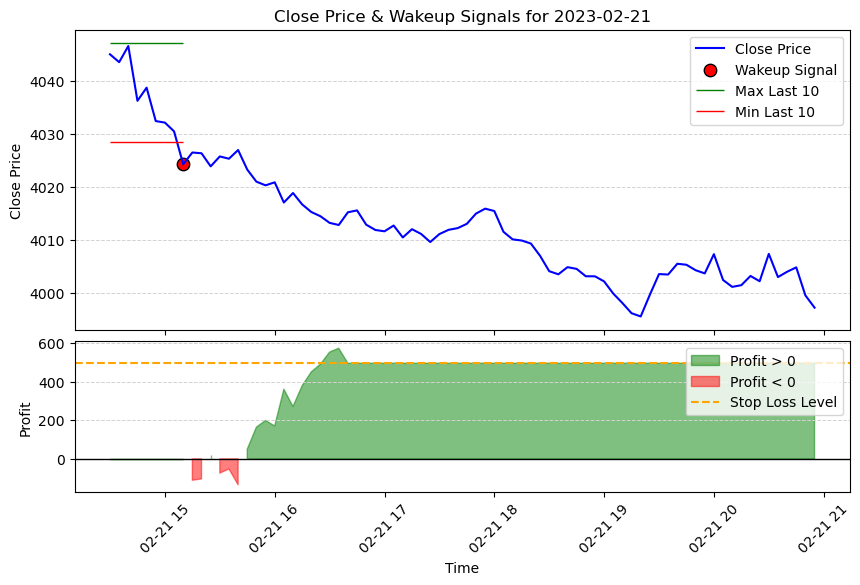

El beneficio al final del día 2023-02-21 en índice 2807 es: 495.0 $
Min Profit of the day: -134.0 $
Max Profit of the day: 573.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-21.jpg


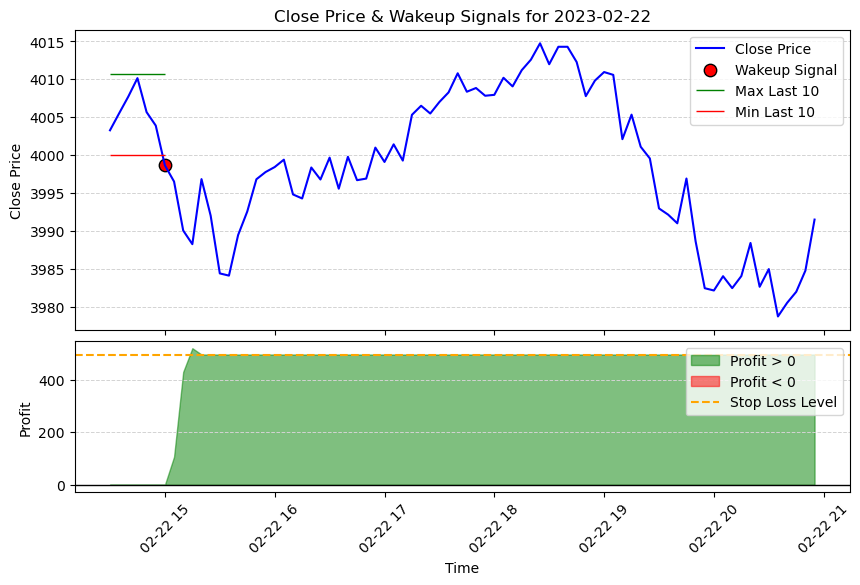

El beneficio al final del día 2023-02-22 en índice 2885 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 519.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-22.jpg


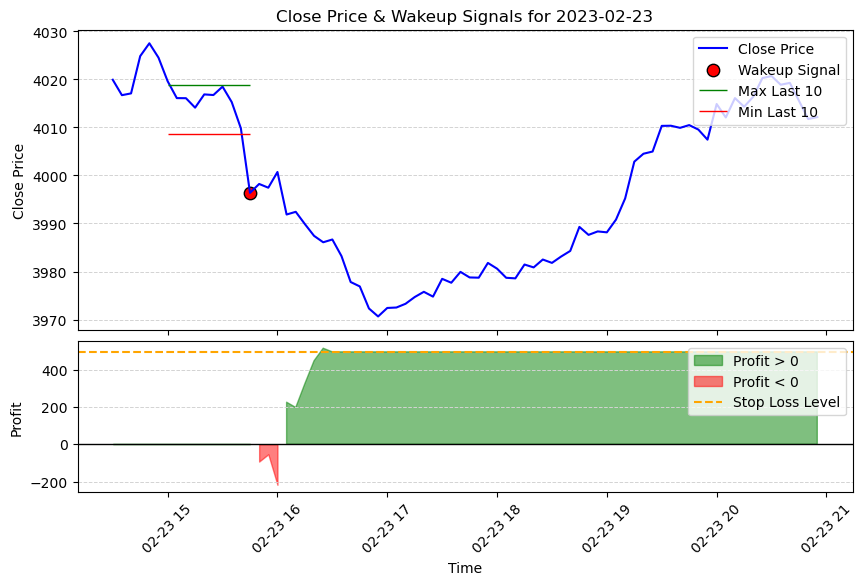

El beneficio al final del día 2023-02-23 en índice 2963 es: 495.0 $
Min Profit of the day: -217.0 $
Max Profit of the day: 514.5 $
Chart saved successfully: Chart\wakeup_signals_2023-02-23.jpg


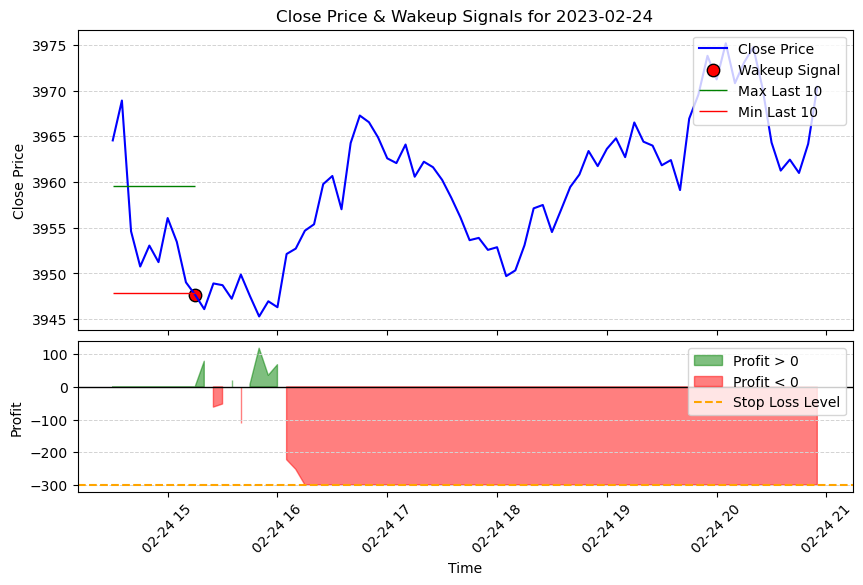

El beneficio al final del día 2023-02-24 en índice 3041 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 118.5 $
Chart saved successfully: Chart\wakeup_signals_2023-02-24.jpg


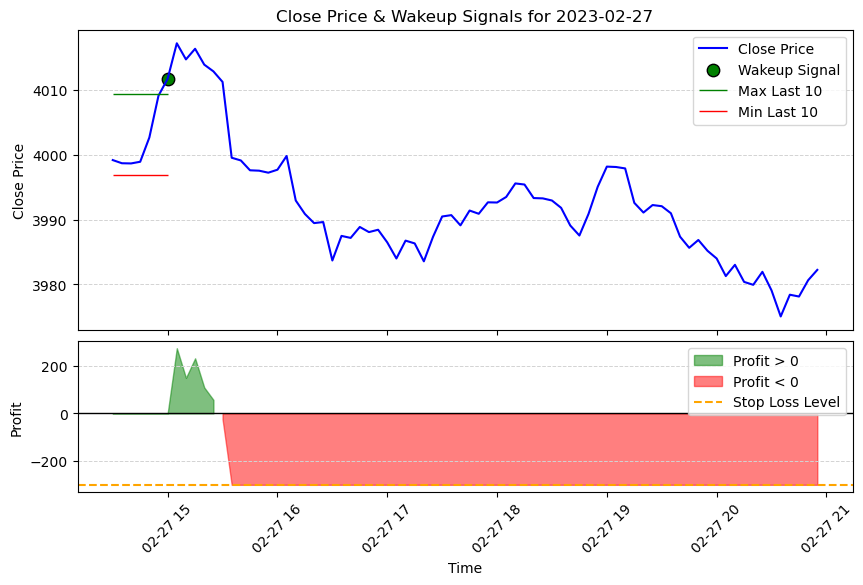

El beneficio al final del día 2023-02-27 en índice 3119 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 274.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-27.jpg


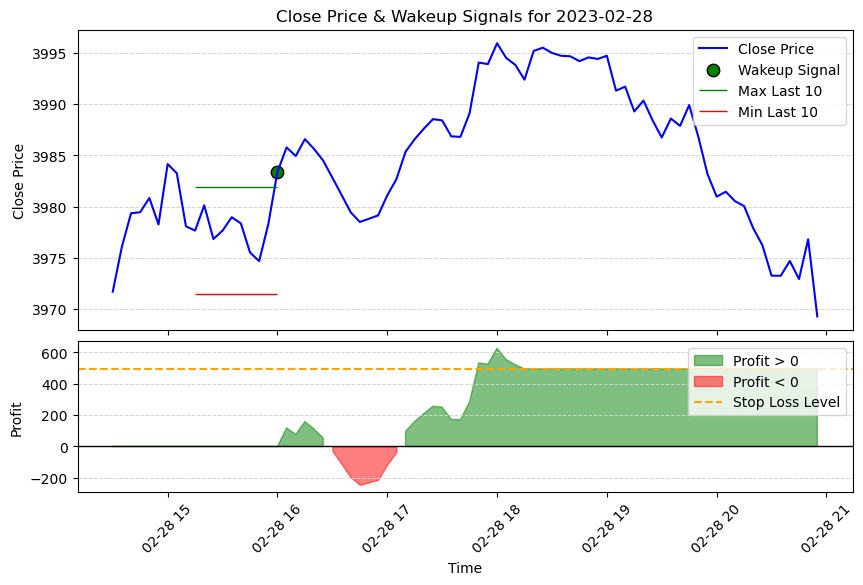

El beneficio al final del día 2023-02-28 en índice 3197 es: 495.0 $
Min Profit of the day: -244.5 $
Max Profit of the day: 627.0 $
Chart saved successfully: Chart\wakeup_signals_2023-02-28.jpg


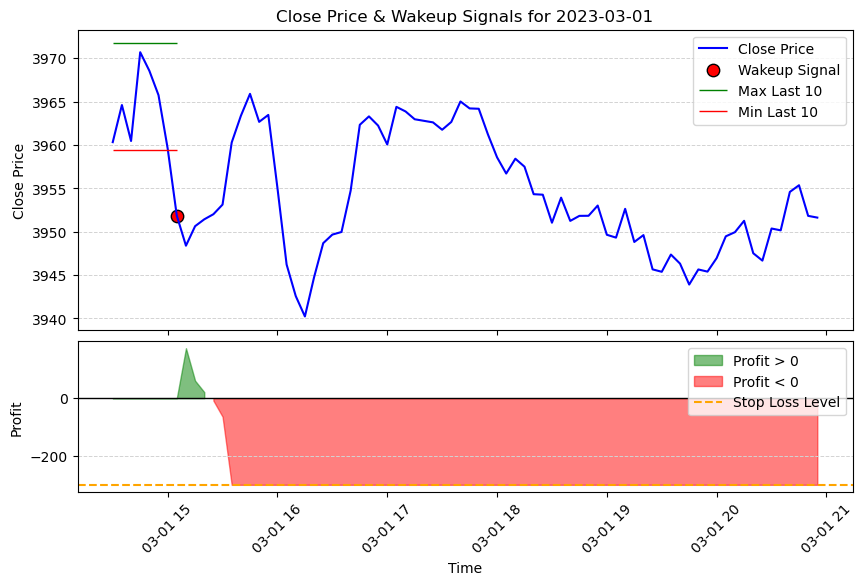

El beneficio al final del día 2023-03-01 en índice 3275 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 173.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-01.jpg


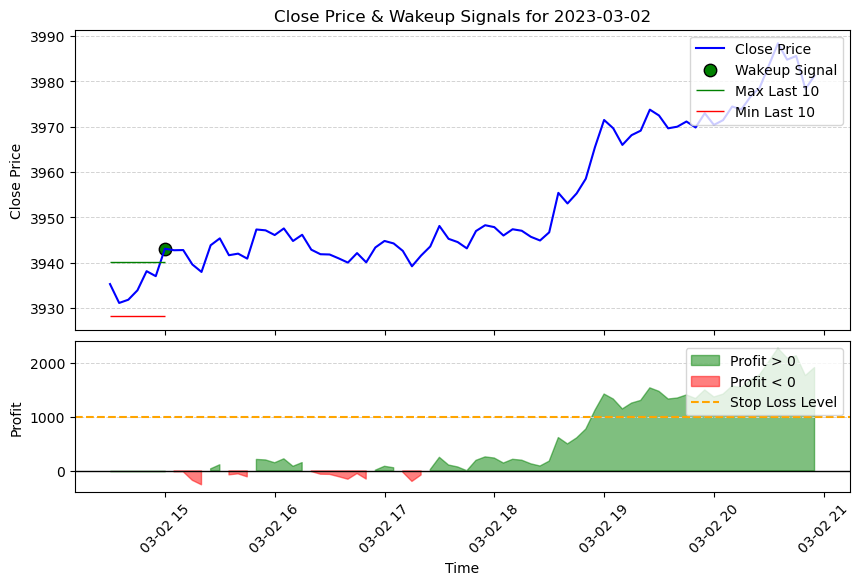

El beneficio al final del día 2023-03-02 en índice 3353 es: 1909.5 $
Min Profit of the day: -256.0 $
Max Profit of the day: 2266.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-02.jpg


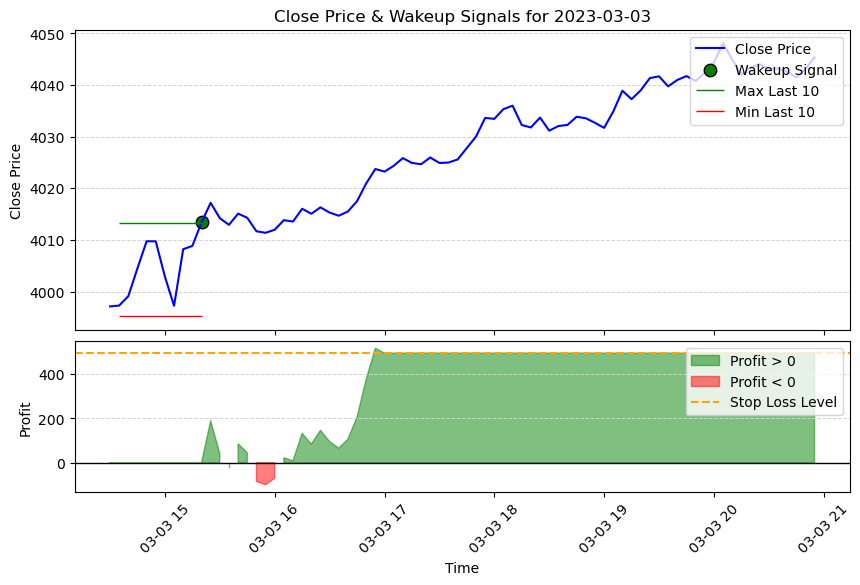

El beneficio al final del día 2023-03-03 en índice 3431 es: 495.0 $
Min Profit of the day: -100.0 $
Max Profit of the day: 517.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-03.jpg


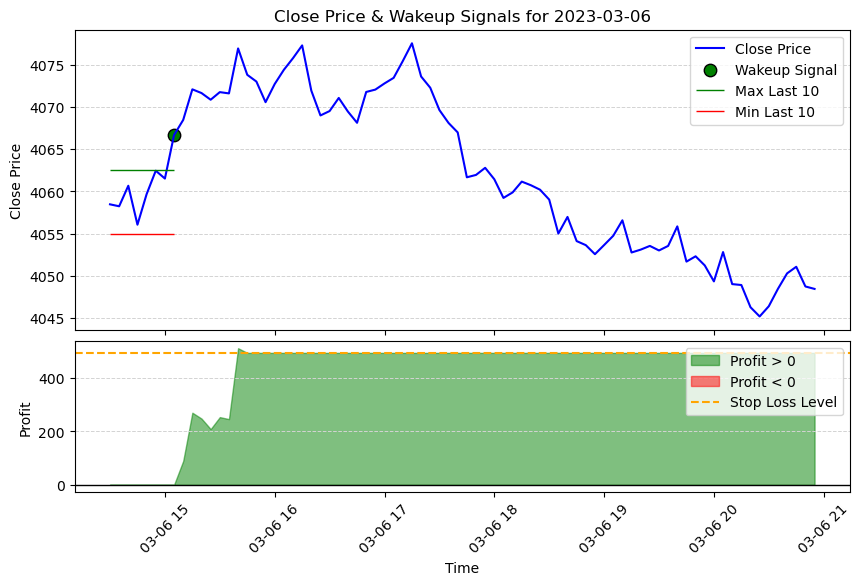

El beneficio al final del día 2023-03-06 en índice 3509 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 512.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-06.jpg


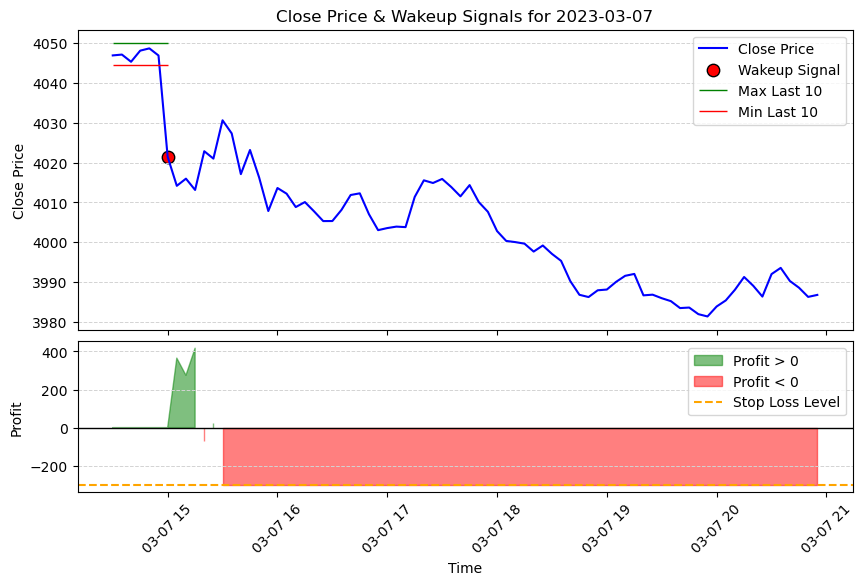

El beneficio al final del día 2023-03-07 en índice 3587 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 417.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-07.jpg


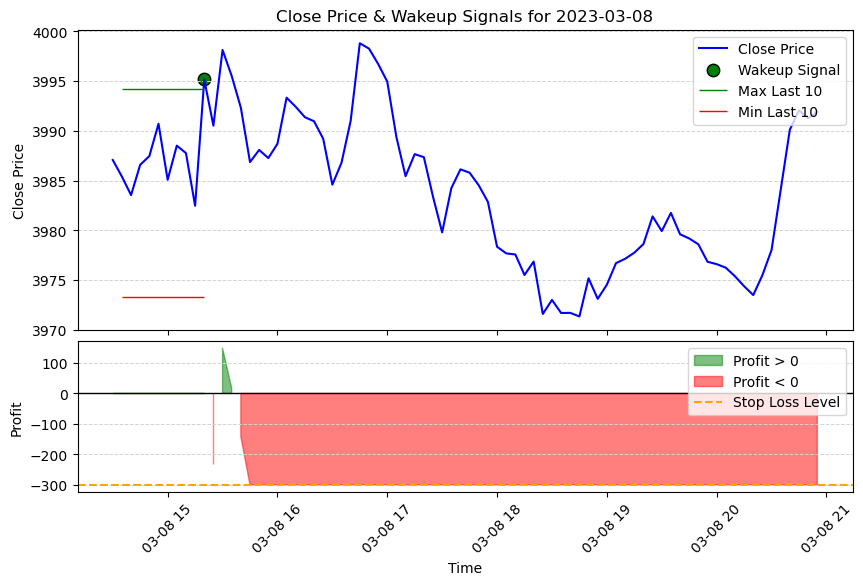

El beneficio al final del día 2023-03-08 en índice 3665 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 148.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-08.jpg


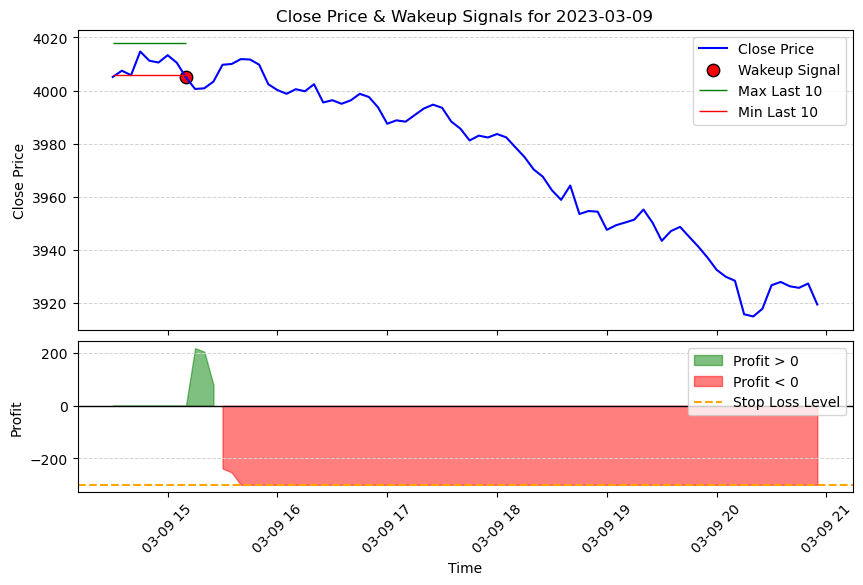

El beneficio al final del día 2023-03-09 en índice 3743 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 218.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-09.jpg


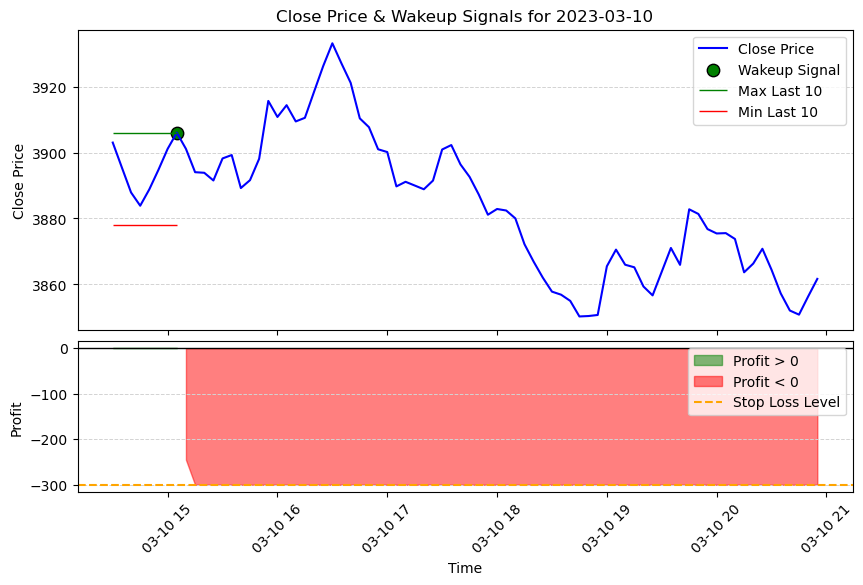

El beneficio al final del día 2023-03-10 en índice 3821 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-10.jpg


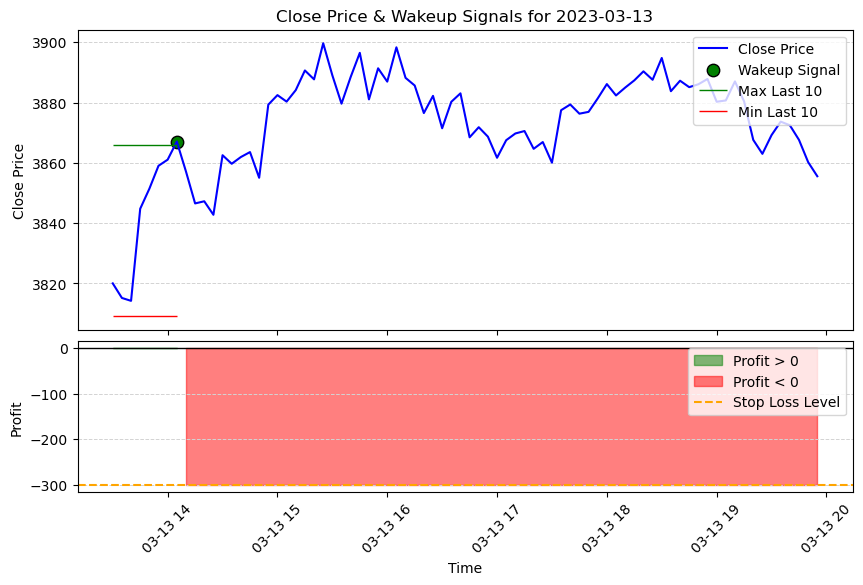

El beneficio al final del día 2023-03-13 en índice 3899 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-13.jpg


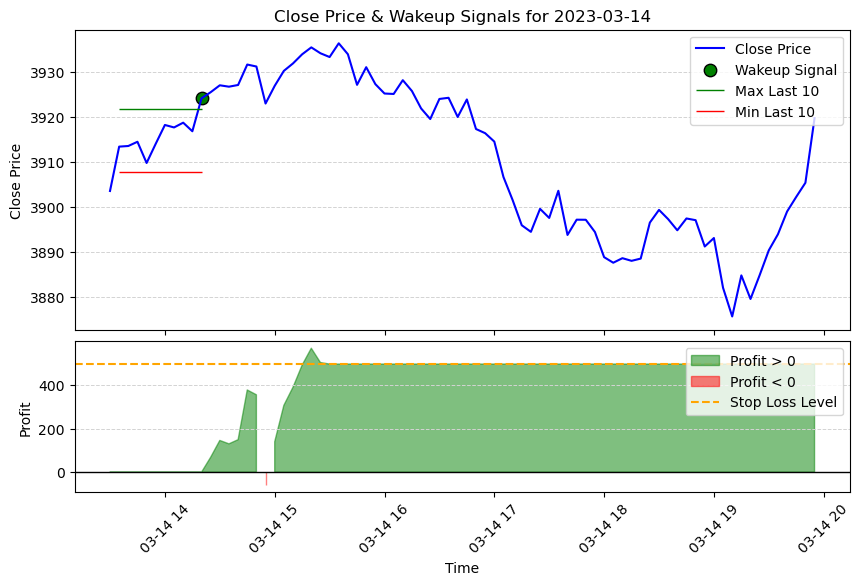

El beneficio al final del día 2023-03-14 en índice 3977 es: 495.0 $
Min Profit of the day: -57.5 $
Max Profit of the day: 567.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-14.jpg


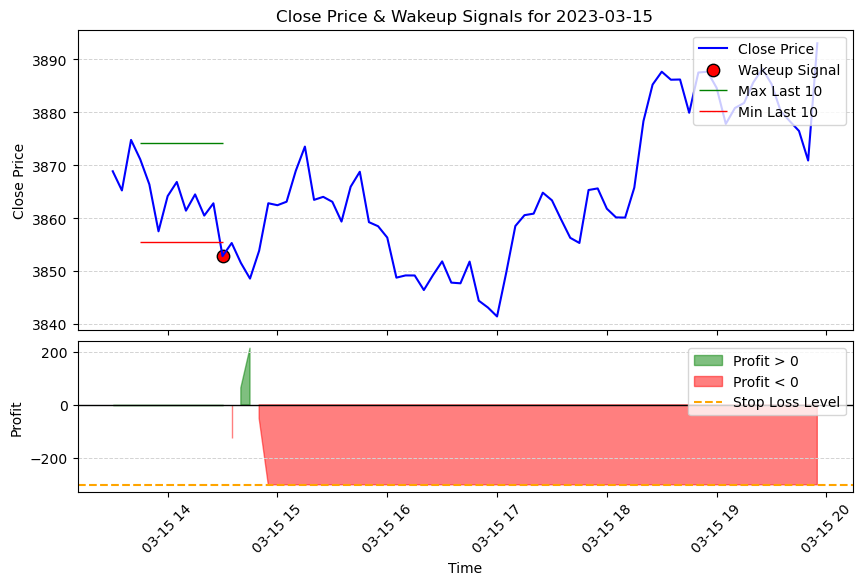

El beneficio al final del día 2023-03-15 en índice 4055 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 212.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-15.jpg


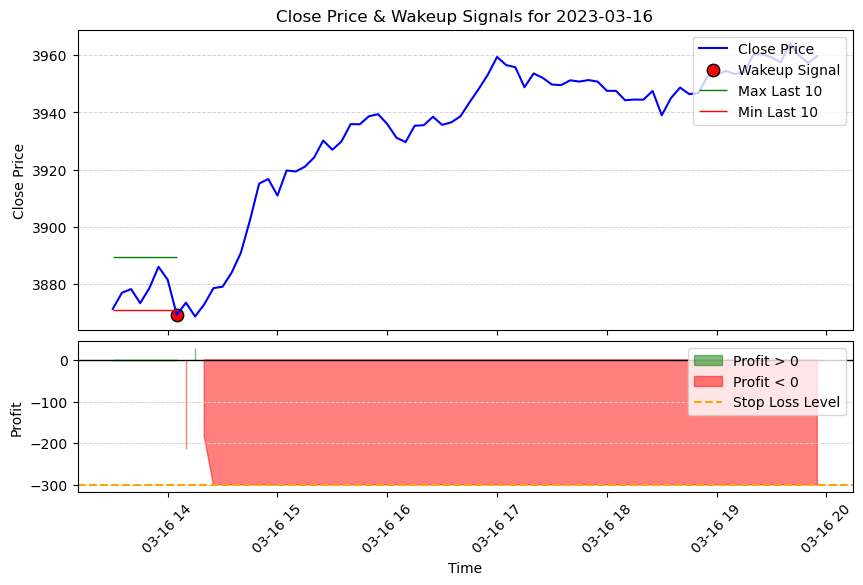

El beneficio al final del día 2023-03-16 en índice 4133 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 28.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-16.jpg


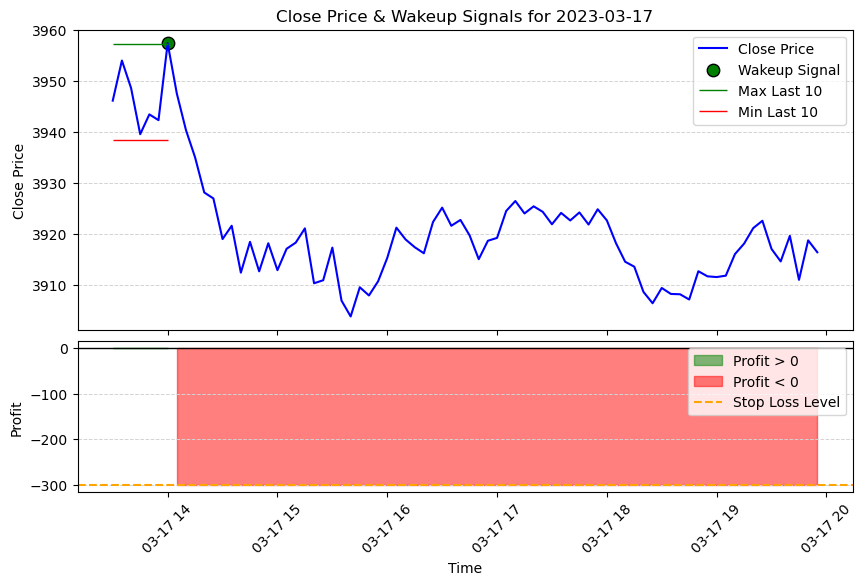

El beneficio al final del día 2023-03-17 en índice 4211 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-17.jpg


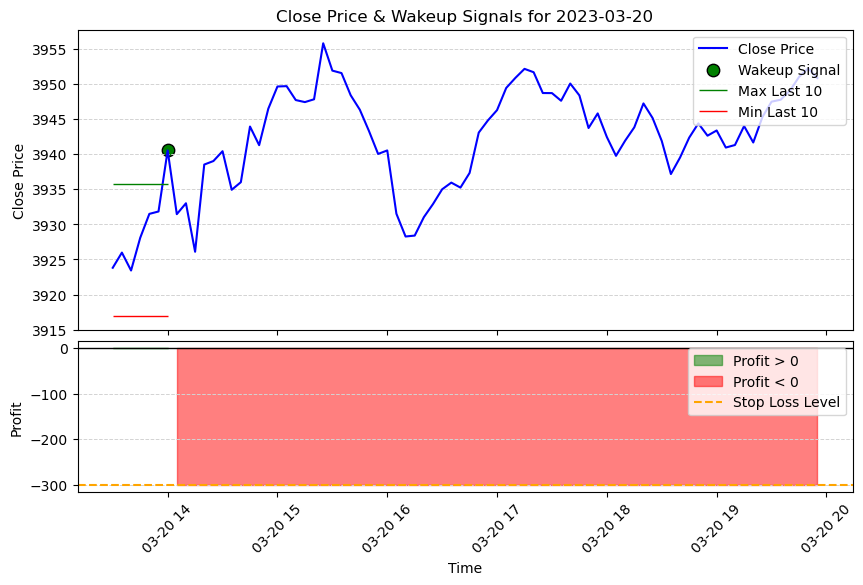

El beneficio al final del día 2023-03-20 en índice 4289 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-20.jpg


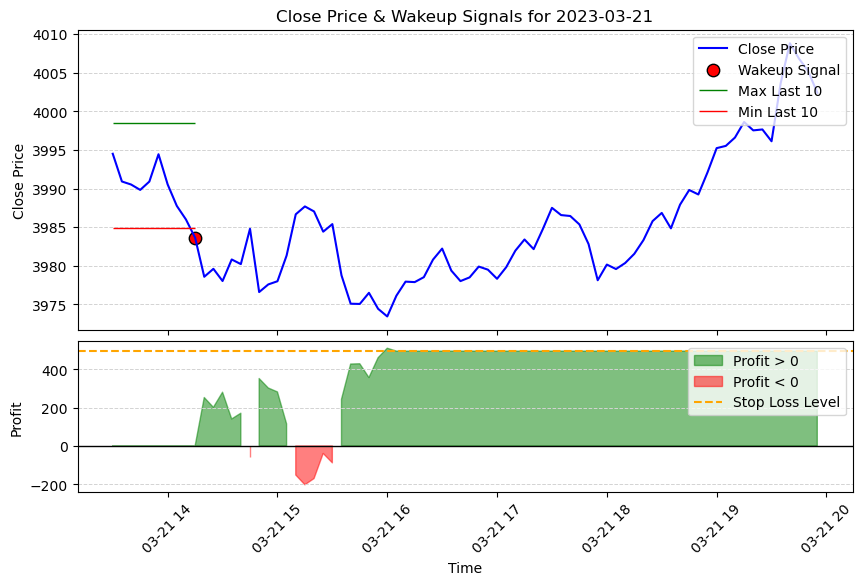

El beneficio al final del día 2023-03-21 en índice 4367 es: 495.0 $
Min Profit of the day: -202.5 $
Max Profit of the day: 510.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-21.jpg


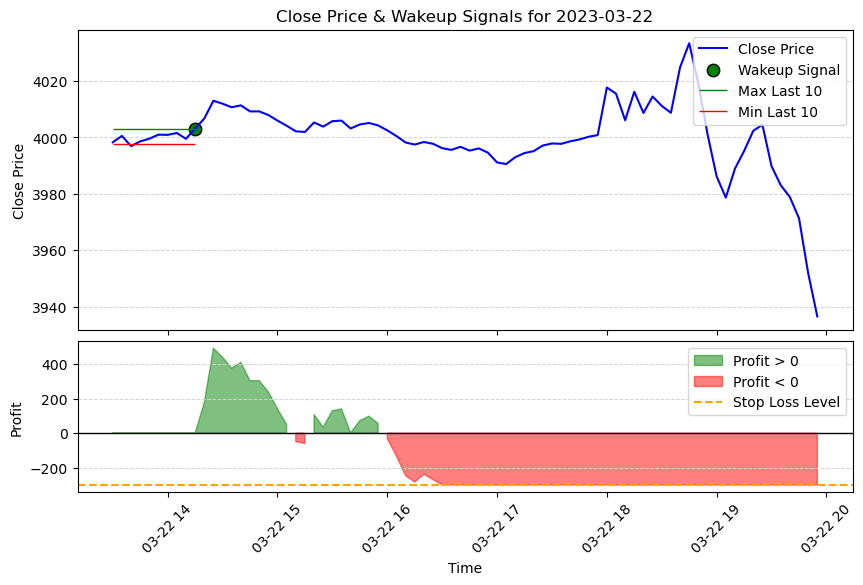

El beneficio al final del día 2023-03-22 en índice 4445 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 493.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-22.jpg


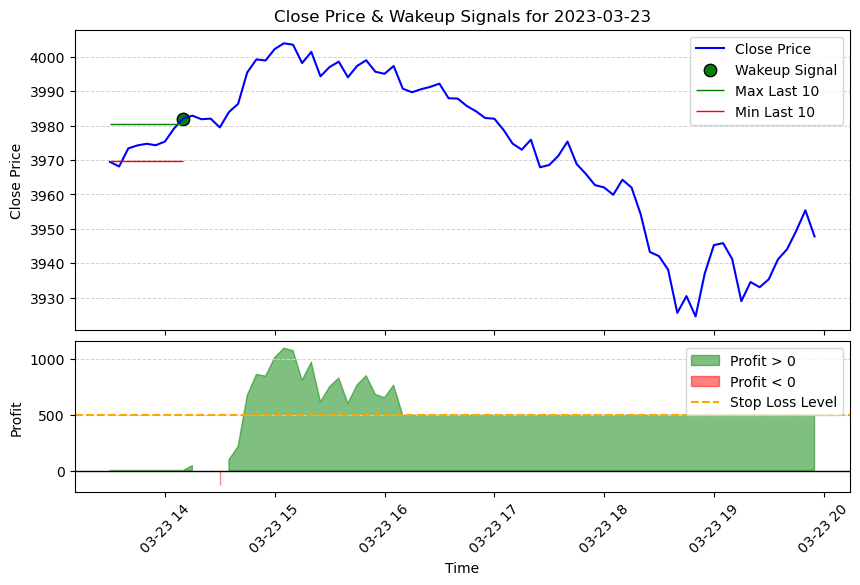

El beneficio al final del día 2023-03-23 en índice 4523 es: 495.0 $
Min Profit of the day: -127.5 $
Max Profit of the day: 1096.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-23.jpg


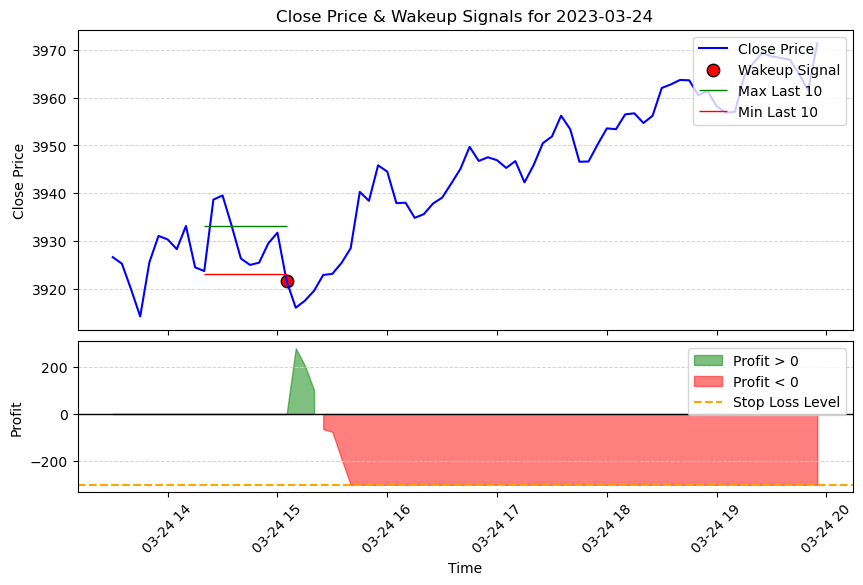

El beneficio al final del día 2023-03-24 en índice 4601 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 278.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-24.jpg


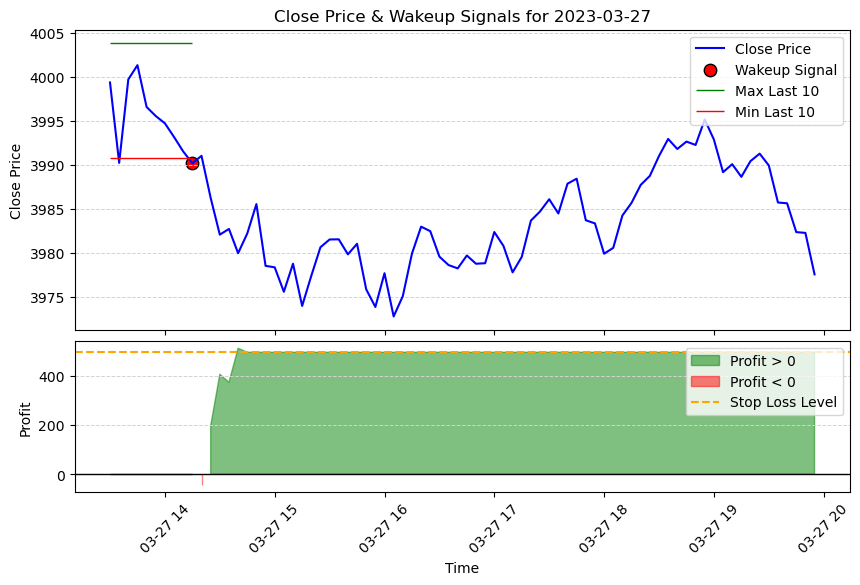

El beneficio al final del día 2023-03-27 en índice 4679 es: 495.0 $
Min Profit of the day: -42.5 $
Max Profit of the day: 511.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-27.jpg


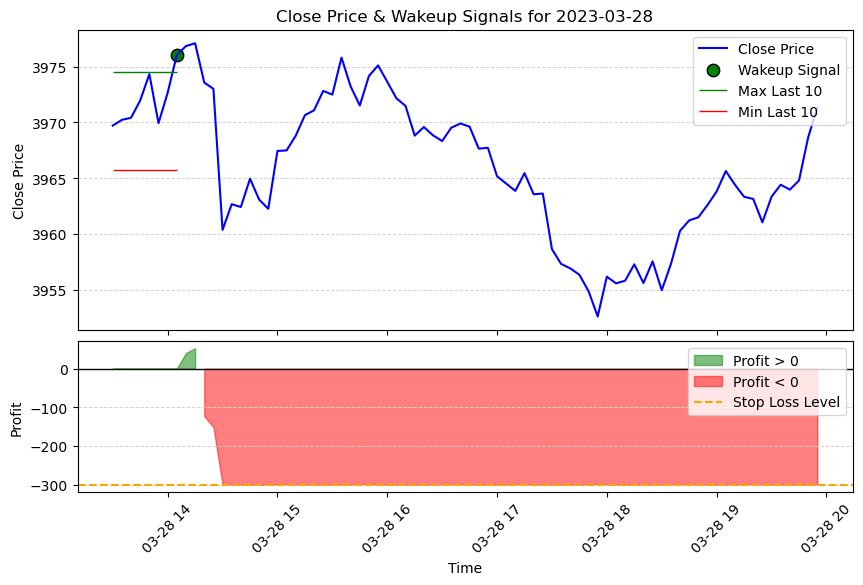

El beneficio al final del día 2023-03-28 en índice 4757 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 52.5 $
Chart saved successfully: Chart\wakeup_signals_2023-03-28.jpg


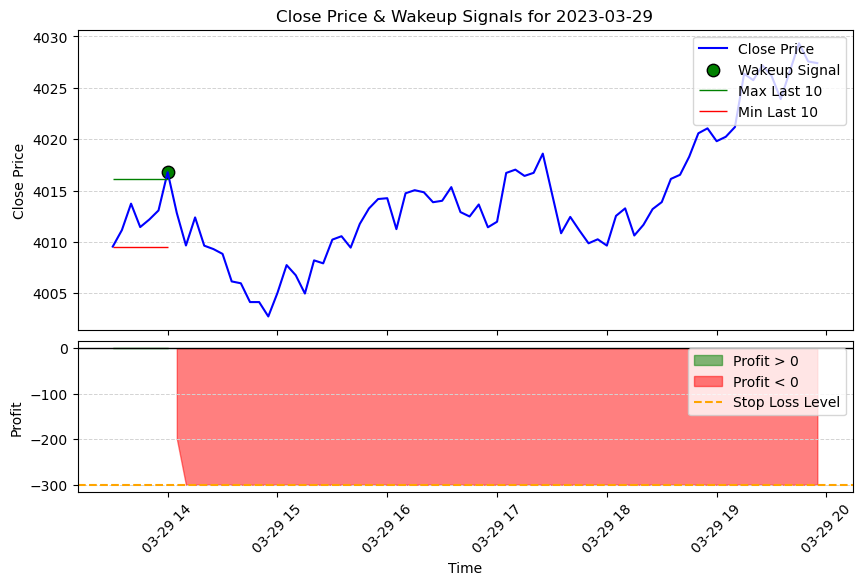

El beneficio al final del día 2023-03-29 en índice 4835 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-29.jpg


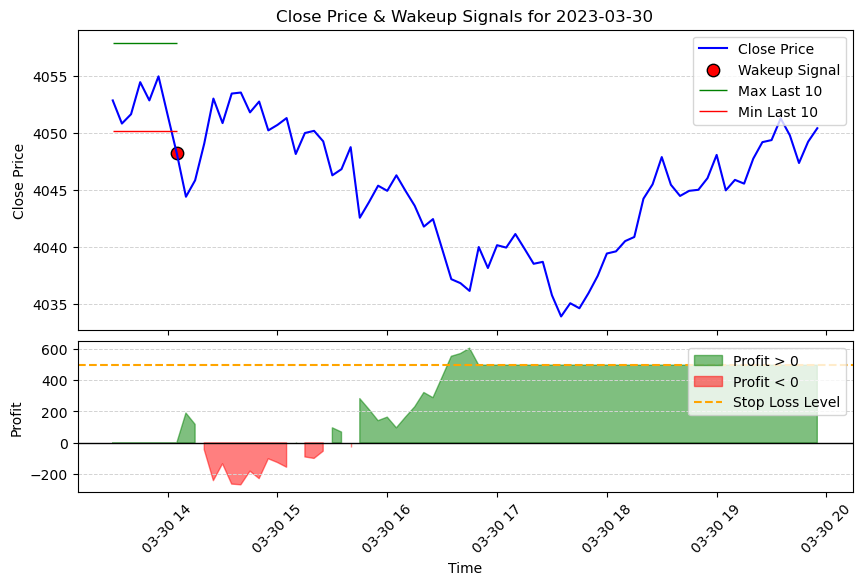

El beneficio al final del día 2023-03-30 en índice 4913 es: 495.0 $
Min Profit of the day: -267.0 $
Max Profit of the day: 603.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-30.jpg


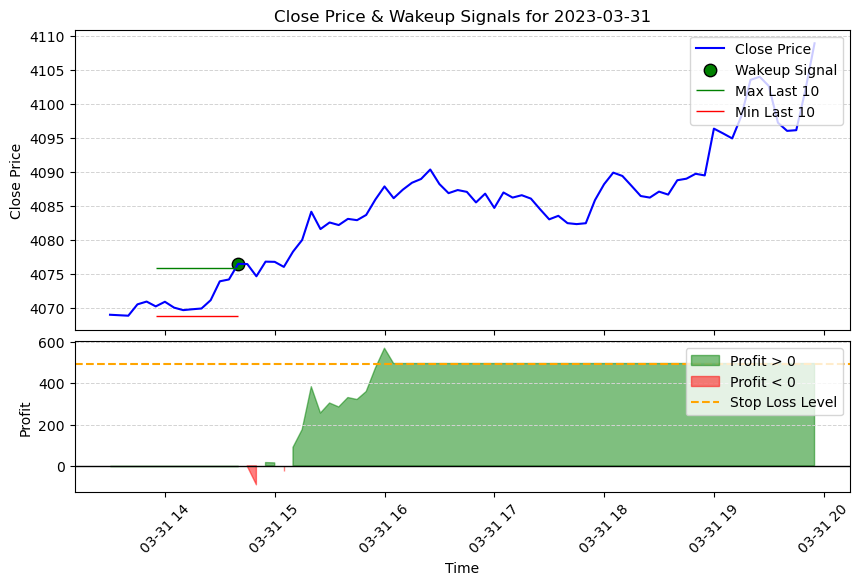

El beneficio al final del día 2023-03-31 en índice 4991 es: 495.0 $
Min Profit of the day: -91.5 $
Max Profit of the day: 569.0 $
Chart saved successfully: Chart\wakeup_signals_2023-03-31.jpg


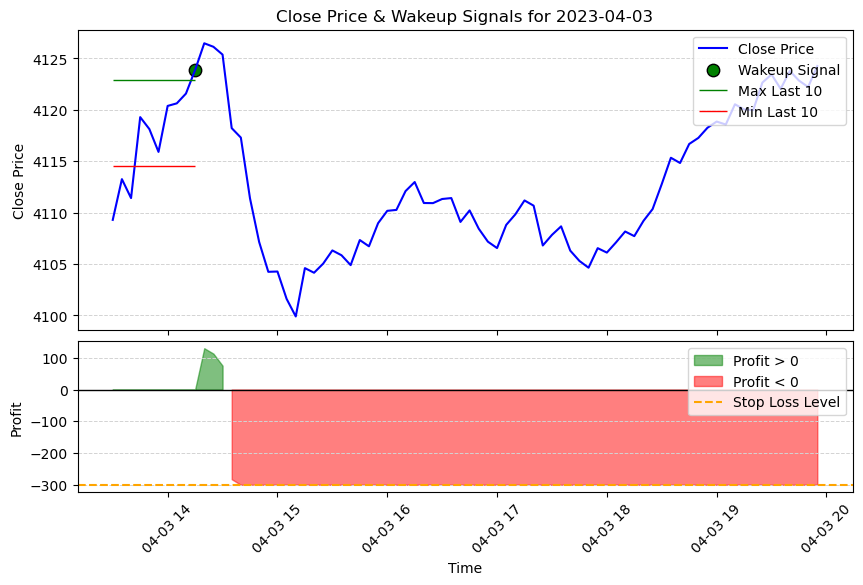

El beneficio al final del día 2023-04-03 en índice 5069 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 130.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-03.jpg


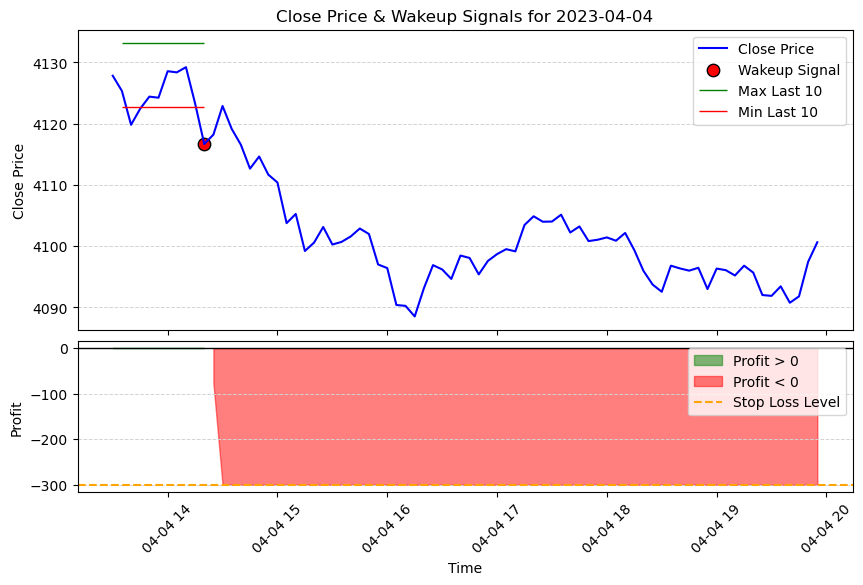

El beneficio al final del día 2023-04-04 en índice 5147 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-04.jpg


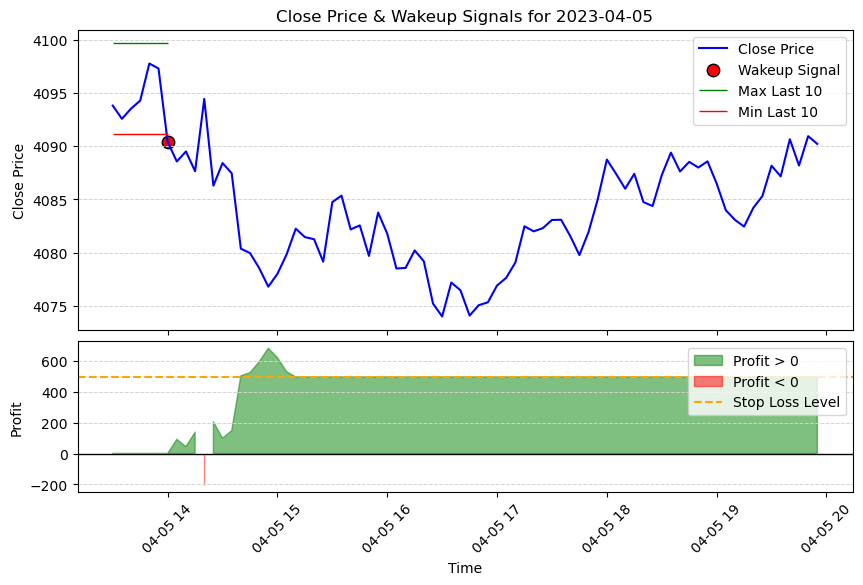

El beneficio al final del día 2023-04-05 en índice 5225 es: 495.0 $
Min Profit of the day: -202.0 $
Max Profit of the day: 680.5 $
Chart saved successfully: Chart\wakeup_signals_2023-04-05.jpg


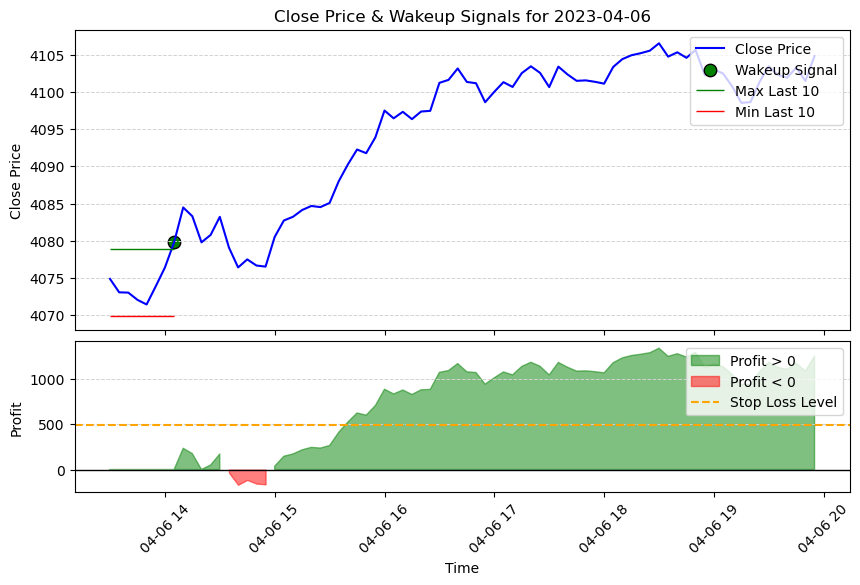

El beneficio al final del día 2023-04-06 en índice 5303 es: 1251.5 $
Min Profit of the day: -167.5 $
Max Profit of the day: 1337.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-06.jpg


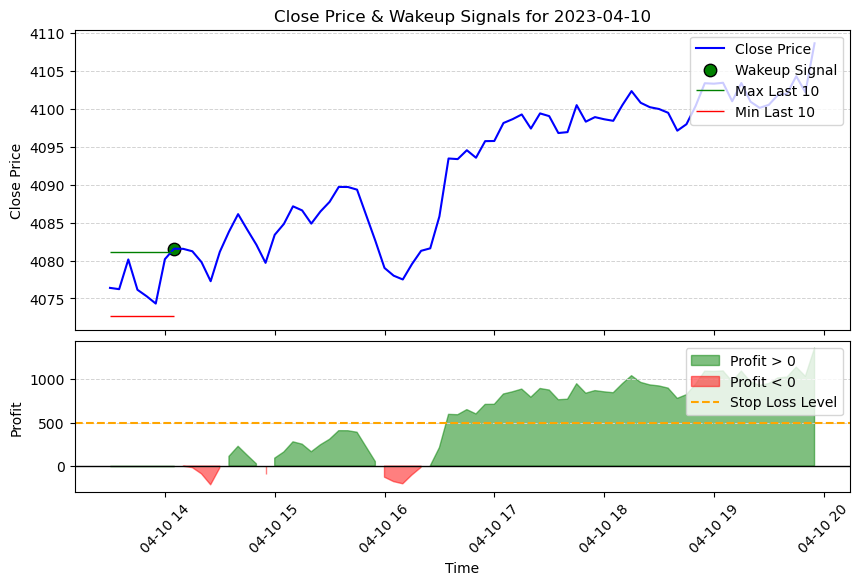

El beneficio al final del día 2023-04-10 en índice 5381 es: 1355.0 $
Min Profit of the day: -214.5 $
Max Profit of the day: 1355.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-10.jpg


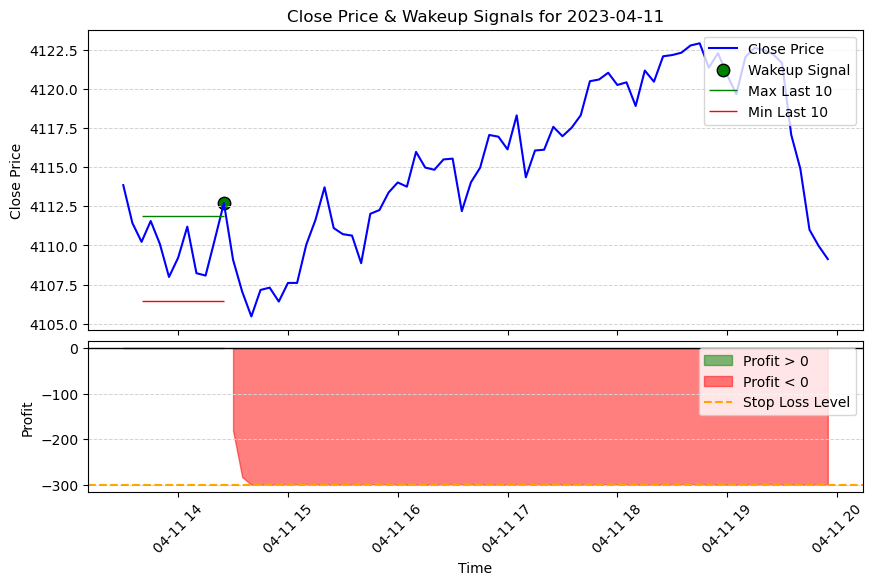

El beneficio al final del día 2023-04-11 en índice 5459 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 0.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-11.jpg


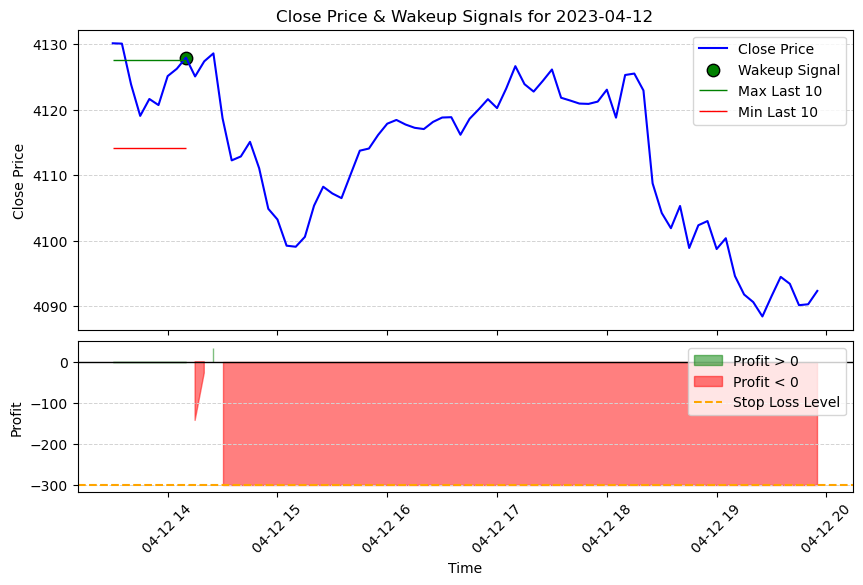

El beneficio al final del día 2023-04-12 en índice 5537 es: -300.0 $
Min Profit of the day: -300.0 $
Max Profit of the day: 33.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-12.jpg


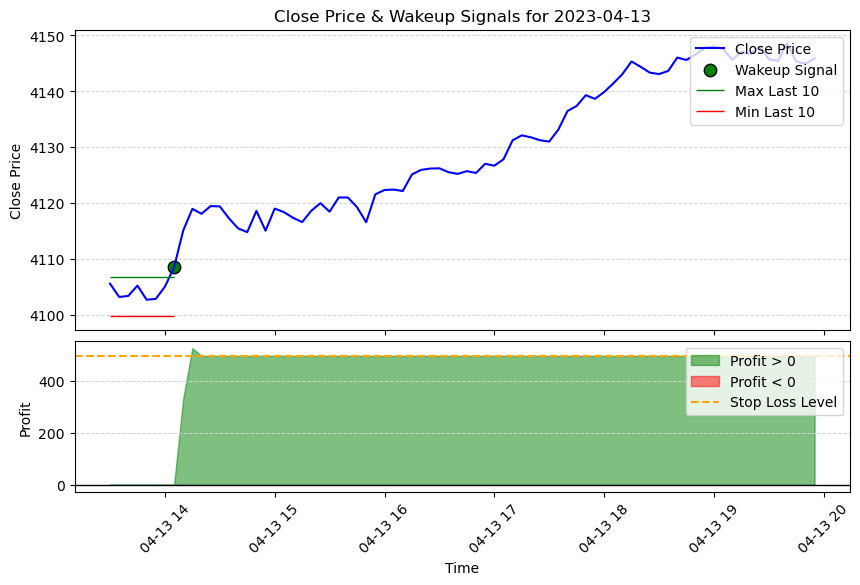

El beneficio al final del día 2023-04-13 en índice 5615 es: 495.0 $
Min Profit of the day: 0.0 $
Max Profit of the day: 524.5 $
Chart saved successfully: Chart\wakeup_signals_2023-04-13.jpg


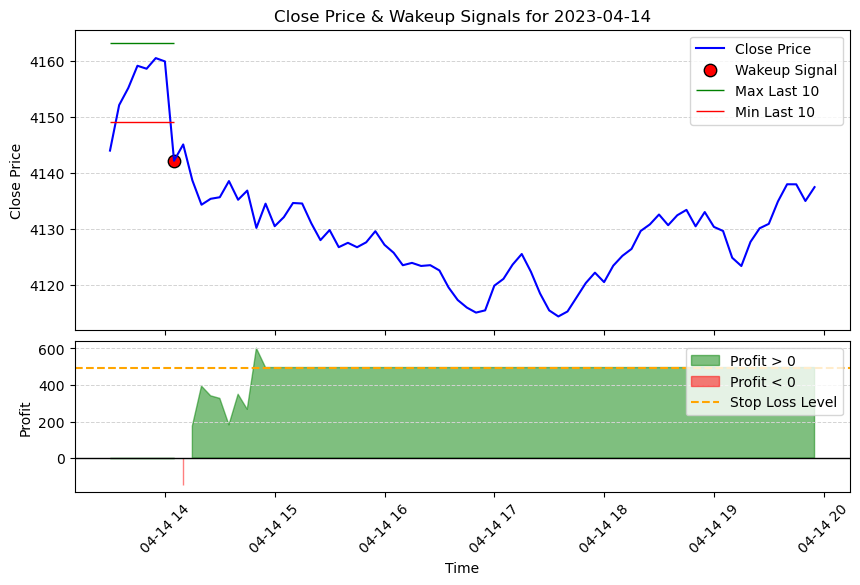

El beneficio al final del día 2023-04-14 en índice 5693 es: 495.0 $
Min Profit of the day: -145.5 $
Max Profit of the day: 600.5 $
Chart saved successfully: Chart\wakeup_signals_2023-04-14.jpg


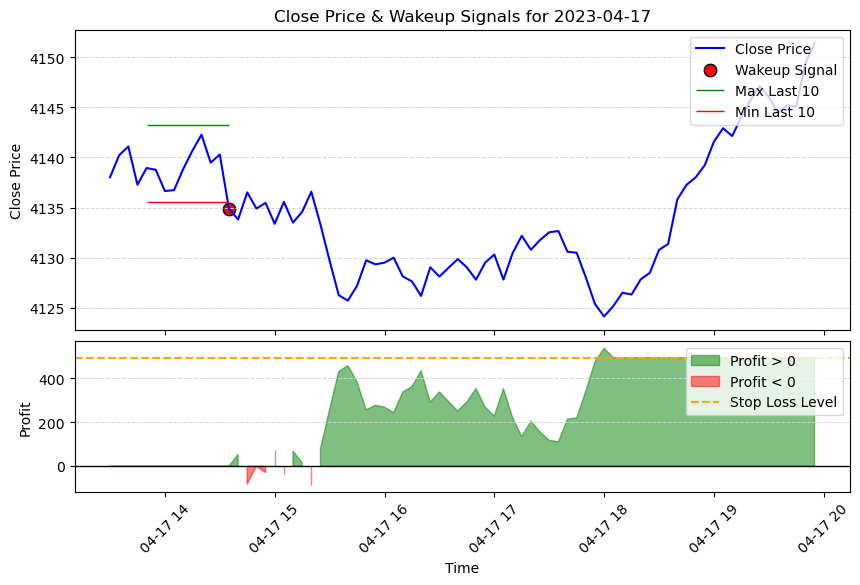

El beneficio al final del día 2023-04-17 en índice 5771 es: 495.0 $
Min Profit of the day: -84.5 $
Max Profit of the day: 538.0 $
Chart saved successfully: Chart\wakeup_signals_2023-04-17.jpg


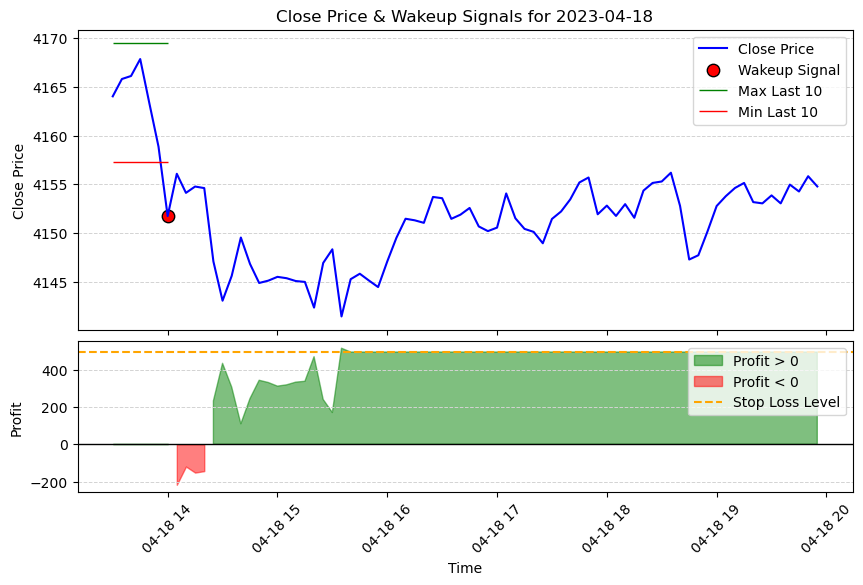

El beneficio al final del día 2023-04-18 en índice 5849 es: 495.0 $
Min Profit of the day: -217.5 $
Max Profit of the day: 515.5 $
Chart saved successfully: Chart\wakeup_signals_2023-04-18.jpg


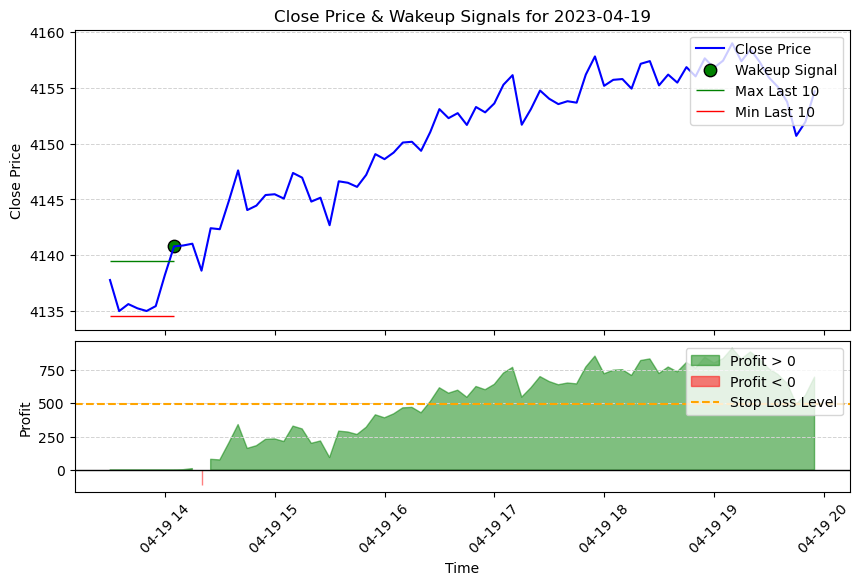

El beneficio al final del día 2023-04-19 en índice 5927 es: 695.5 $
Min Profit of the day: -109.0 $
Max Profit of the day: 911.5 $
Chart saved successfully: Chart\wakeup_signals_2023-04-19.jpg


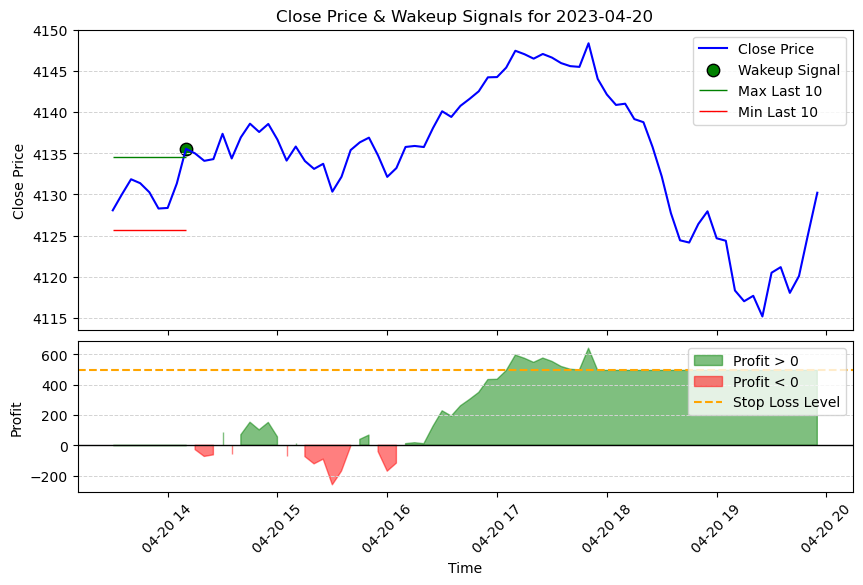

El beneficio al final del día 2023-04-20 en índice 6005 es: 495.0 $
Min Profit of the day: -261.0 $
Max Profit of the day: 641.5 $
Chart saved successfully: Chart\wakeup_signals_2023-04-20.jpg


In [ ]:
# iteración sobre todos los días disponibles
for date in formatted_dates:
    chart_path, summary_df = plot_wakeup_signals(df, date, summary_df)    

# Display the final summary_df after all calls
print("\nFinal Summary DataFrame:")
#summary_df

In [ ]:
# Ensure 'profit' column is numeric
summary_df["profit"] = pd.to_numeric(summary_df["profit"], errors='coerce')

# Compute cumulative profit by adding current 'profit' to previous 'cumprofit'
summary_df["cumprofit"] = summary_df["profit"]

# Iterate through rows starting from the second row to add previous cumprofit value
for i in range(1, len(summary_df)):
    summary_df.loc[i, "cumprofit"] += summary_df.loc[i - 1, "cumprofit"]

In [ ]:
summary_df = summary_df.round(2)
summary_df

In [ ]:
# Define the file path
csv_file_path = "summary_df.csv"  # You can change the filename if needed

# Save to CSV
summary_df.to_csv(csv_file_path, index=False)
print(f"Summary DataFrame saved successfully as {csv_file_path}")

In [ ]:
# Calcular profit total
total_profit = summary_df["profit"].sum()
formatted_profit_T = "{:,.2f}".format(total_profit).replace(",", "X").replace(".", ",").replace("X", ".")

print(f'El beneficio total del sistema durante 2022-2023-2024-2025 es de: {formatted_profit_T} €')
# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(summary_df.index, summary_df["cumprofit"], where=(summary_df["cumprofit"] >= 0), color="green", alpha=0.6)
ax.fill_between(summary_df.index, summary_df["cumprofit"], where=(summary_df["cumprofit"] < 0), color="red", alpha=0.6)

# Configuración
ax.axhline(0, color="black", linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Profit")
ax.set_title(f"Beneficio al final de todos los años: {formatted_profit_T} $")
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [ ]:
# Define the file path
csv_file_path = "summary_df_stop_600.csv"  # You can change the filename if needed

# Save to CSV
summary_df.to_csv(csv_file_path, index=False)
print(f"Summary DataFrame saved successfully as {csv_file_path}")

In [ ]:
# Create histogram plot for the 'profit' column
plt.figure(figsize=(10, 6))
plt.hist(summary_df["profit"], bins=40, edgecolor="black", alpha=0.7,color='orange')
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Histogram of Profit Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create histogram plot for the 'profit' column
plt.figure(figsize=(10, 6))
plt.hist(summary_df["min_profit"], bins=40, edgecolor="black", alpha=0.7,color='red')
plt.xlabel("Lost")
plt.ylabel("Frequency")
plt.title("Histogram of min_profit  Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Create histogram plot for the 'profit' column
plt.figure(figsize=(10, 6))
plt.hist(summary_df["max_profit"], bins=40, edgecolor="black", alpha=0.7,color='green')
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Histogram of max_profit  Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import pandas as pd

def calculate_summary_statistics(summary_df):
    # Basic Statistics
    mean_profit = round(summary_df["profit"].mean(), 2)
    median_profit = round(summary_df["profit"].median(), 2)
    std_profit = round(summary_df["profit"].std(), 2)
    min_profit = round(summary_df["profit"].min(), 2)
    max_profit = round(summary_df["profit"].max(), 2)

    # Performance Ratios
    win_days = (summary_df["profit"] > 0).sum()
    loss_days = (summary_df["profit"] < 0).sum()
    total_days = len(summary_df)

    win_rate = round((win_days / total_days) * 100, 2) if total_days > 0 else 0
    loss_rate = round((loss_days / total_days) * 100, 2) if total_days > 0 else 0

    total_profit = summary_df.loc[summary_df["profit"] > 0, "profit"].sum()
    total_loss = abs(summary_df.loc[summary_df["profit"] < 0, "profit"].sum())

    mean_loss = round(summary_df.loc[summary_df["profit"] < 0, "profit"].mean(), 2) if loss_days > 0 else 0
    win_loss_ratio = round(total_profit / total_loss, 2) if total_loss > 0 else float("inf")

    profit_factor = round(total_profit / total_loss, 2) if total_loss > 0 else float("inf")
    sharpe_ratio = round(mean_profit / std_profit, 2) if std_profit > 0 else float("inf")

    # Max Drawdown Calculation (Cumulative Loss before New High)
    cumulative_profit = summary_df["profit"].cumsum()
    rolling_max = cumulative_profit.cummax()
    drawdown = rolling_max - cumulative_profit
    max_drawdown = round(drawdown.max(), 2)

    # Results DataFrame
    stats_df = pd.DataFrame({
        "Metric": [
            "Mean Profit", "Median Profit", "Std Dev Profit", "Min Profit", "Max Profit",
            "Win Rate (%)", "Loss Rate (%)", "Profit Factor", "Sharpe Ratio", "Max Drawdown",
            "Mean Loss", "Win/Loss Ratio"
        ],
        "Value": [
            mean_profit, median_profit, std_profit, min_profit, max_profit,
            win_rate, loss_rate, profit_factor, sharpe_ratio, max_drawdown,
            mean_loss, win_loss_ratio
        ]
    })

    return stats_df

# Example Usage
# summary_df should be a DataFrame with a column "profit"
stats_df = calculate_summary_statistics(summary_df)
print(stats_df)